# Analysis of the Boats data

In [1]:
import pandas as pd

import numpy as np

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage  
import scipy.cluster.hierarchy as shc

import cufflinks as cf
cf.set_config_file(offline=True)
import plotly.express as px
import plotly.graph_objects as go

from sklearn import metrics
from sklearn import neural_network
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

#import glmnet
#from glmnet import glmnet

import xgboost as xgb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url = '/Boats_bookings.csv'
boats = pd.read_csv(url)

In [ ]:
boats.head()

CHARTER ID  AVAILABILITY  ... 22.12.2018.  29.12.2018.
0        2996             0  ...    3630.0 €          NaN
1         800             2  ...    2550.0 €          NaN
2        1230             0  ...    3600.0 €     3600.0 €
3        1856             2  ...    1590.0 €          NaN
4        2682             1  ...         NaN          NaN

[5 rows x 70 columns]

In [3]:
#We need to remove the euro sign and transform the prices into floats
boats[boats.columns[17:]] = boats[boats.columns[17:]].replace('[\€,]', '', regex=True).astype(float)
pricesBoats = boats[boats.columns[17:]]

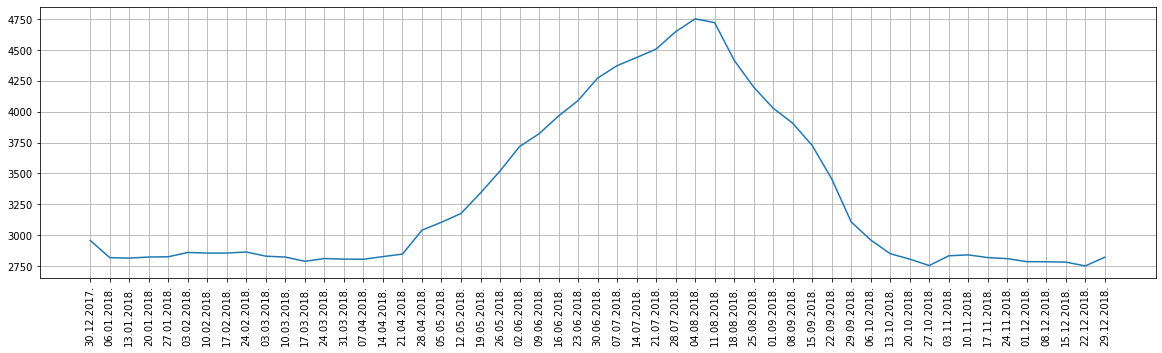

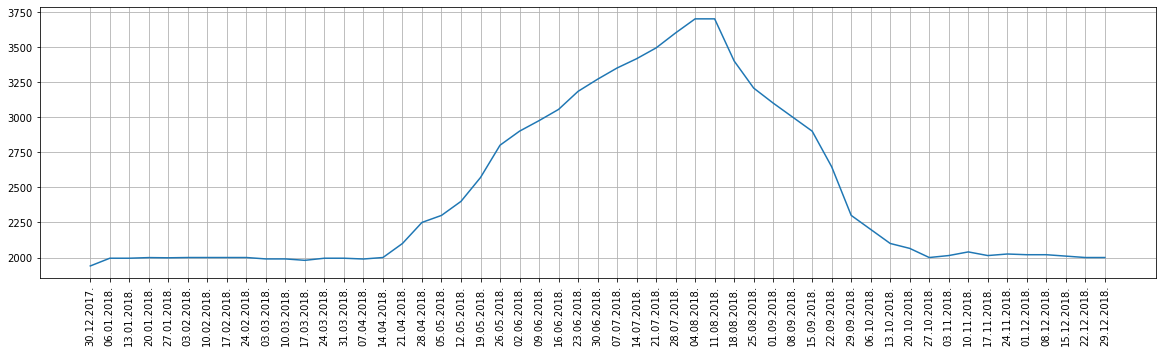

In [ ]:
#To identify the peak season, we can use prices, which according to market rules reflect the amont of demand. 
#So, most expensive weeks will be the actual peak season

#Compute average prices for each date and plot them to identify most expensive weeks 
plt.figure(figsize=(20,5))
plt.plot(pricesBoats.mean())
plt.xticks(pricesBoats.mean().index, rotation='vertical')
plt.grid()

#Compute median prices for each date and plot them to identify most expensive weeks
plt.figure(figsize=(20,5))
plt.plot(pricesBoats.median())
plt.xticks(pricesBoats.median().index, rotation='vertical')
plt.grid()



In [ ]:
#Obviously, the most expensive period appeared to be during the summer.
#In particular, the beginning of the august (dates 04.08 - 11.08) is the most expensive period.
#July and august are the most expensive moths. So, since we aim at prediction prices for the whole peak season, we can consider dates from 30.06 to 25.08 as a peak season.

In [4]:
pricesBoats = pricesBoats[['30.06.2018.', '07.07.2018.', '14.07.2018.', '21.07.2018.', '28.07.2018.', '04.08.2018.', '11.08.2018.', '18.08.2018.', '25.08.2018.']]
pricesBoats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   30.06.2018.  7471 non-null   float64
 1   07.07.2018.  7443 non-null   float64
 2   14.07.2018.  7471 non-null   float64
 3   21.07.2018.  7491 non-null   float64
 4   28.07.2018.  7483 non-null   float64
 5   04.08.2018.  7540 non-null   float64
 6   11.08.2018.  7535 non-null   float64
 7   18.08.2018.  7514 non-null   float64
 8   25.08.2018.  7546 non-null   float64
dtypes: float64(9)
memory usage: 572.3 KB


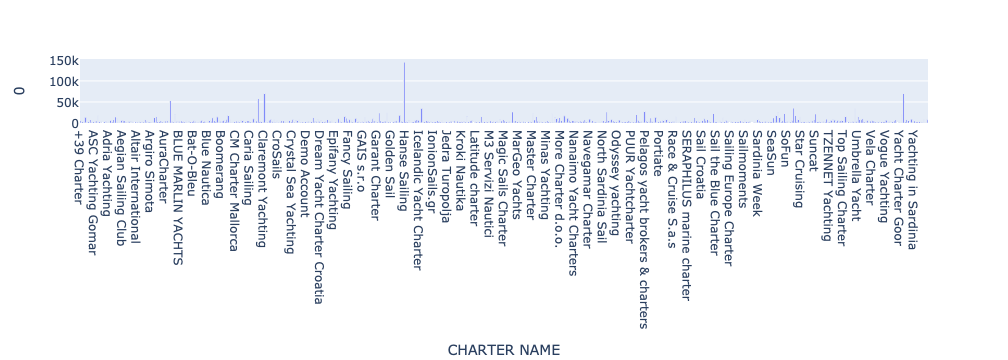

In [5]:
#Lets consider average prices per each charter during this time
pricesCharters = boats.groupby('CHARTER NAME')[pricesBoats.columns].mean().mean(axis=1)
#Plot prices to find outliers
fig = px.bar(pricesCharters.reset_index(), x='CHARTER NAME', y=0)
fig.show()

In [ ]:
#Price outliers
boats[(boats['CHARTER NAME']=='Halas 71')|
      (boats['CHARTER NAME']=='Claremont Yachting')|
      (boats['CHARTER NAME']=='Cem Insaat')|
      (boats['CHARTER NAME']=='Azalea Cruise')|
      (boats['CHARTER NAME']=='Yacht Marine')]

CHARTER ID  AVAILABILITY  ... 22.12.2018.  29.12.2018.
1404        3331             2  ...   70000.000          NaN
1794        1398             2  ...         NaN          NaN
4960        1398             2  ...   87500.000          NaN
5136        1398             2  ...   80000.000          NaN
5155        1398             2  ...   80000.000          NaN
6133        2435             2  ...         NaN          NaN
6598        2666             0  ...  128030.000          NaN
6621        1398             2  ...         NaN          NaN
7577        2397             2  ...   57757.246    57757.246
8081        1398             2  ...         NaN          NaN

[10 rows x 70 columns]

In [6]:
#Explore features
boats_characteristics = boats[boats.columns[0:17]]
#Drop ids
boats_characteristics=boats_characteristics.drop(columns=['YACHT ID', 'MODEL ID'])
boats_characteristics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CHARTER ID     8137 non-null   int64  
 1   AVAILABILITY   8137 non-null   int64  
 2   CHARTER NAME   8137 non-null   object 
 3   BRAND          8137 non-null   object 
 4   MODEL          8137 non-null   object 
 5   TYPE           8137 non-null   object 
 6   YEAR OF BUILD  8137 non-null   object 
 7   LENGTH         8137 non-null   float64
 8   L FEET         8137 non-null   float64
 9   CABINS         8137 non-null   object 
 10  BERTHS         8137 non-null   object 
 11  BASE           8135 non-null   object 
 12  COUNTRY        8135 non-null   object 
 13  REGION         8080 non-null   object 
 14  RESERVATIONS   6591 non-null   float64
dtypes: float64(3), int64(2), object(10)
memory usage: 953.7+ KB


In [ ]:
boats_characteristics.head(2)

CHARTER ID  AVAILABILITY  ...                           REGION RESERVATIONS
0        2996             0  ...  Cyclades, Athens / Saronic Gulf        119.0
1         800             2  ...                            Split        102.0

[2 rows x 15 columns]

In [ ]:
boats_characteristics.head(3)

CHARTER ID  AVAILABILITY  ...                           REGION RESERVATIONS
0        2996             0  ...  Cyclades, Athens / Saronic Gulf        119.0
1         800             2  ...                            Split        102.0
2        1230             0  ...                   Tyrrhenian Sea         49.0

[3 rows x 15 columns]

In [7]:
#We need to convert numerical variables 'CABINS' and 'BERTHS' into float types
#To do this, first we need to replace '-' with 0 
boats_characteristics['CABINS'] = boats_characteristics['CABINS'].apply(lambda l: l.replace('-','0')).astype(float)
boats_characteristics['BERTHS'] = boats_characteristics['BERTHS'].apply(lambda l: l.replace('-','0')).astype(float)

In [8]:
#We also can encode the year of build as a float to see if there is any dependency.
print(boats_characteristics['YEAR OF BUILD'].unique())
boats_characteristics.loc[boats_characteristics['YEAR OF BUILD'] == '-', 'YEAR OF BUILD']=None
boats_characteristics.loc[boats_characteristics['YEAR OF BUILD'] == '1', 'YEAR OF BUILD']=None
boats_characteristics.loc[boats_characteristics['YEAR OF BUILD'] == '2', 'YEAR OF BUILD']=None
boats_characteristics.loc[boats_characteristics['YEAR OF BUILD'] == '3', 'YEAR OF BUILD']=None
boats_characteristics.loc[boats_characteristics['YEAR OF BUILD'] == '2106', 'YEAR OF BUILD']=None
boats_characteristics['YEAR OF BUILD'] = boats_characteristics['YEAR OF BUILD'].astype(float)

['2018' '2016' '2011' '1996' '2003' '2015' '2009' '2017' '2012' '2004'
 '2010' '-' '2008' '2014' '2000' '2013' '1998' '2006' '2007' '2002' '2019'
 '2005' '1950' '1991' '1' '1994' '2106' '1984' '1981' '1987' '1995' '1993'
 '1990' '2001' '1966' '1989' '1999' '1992' '1997' '1986' '1988' '1985'
 '1978' '2' '3' '1926' '1977' '1983' '1970' '1975' '1914' '1964' '1971']


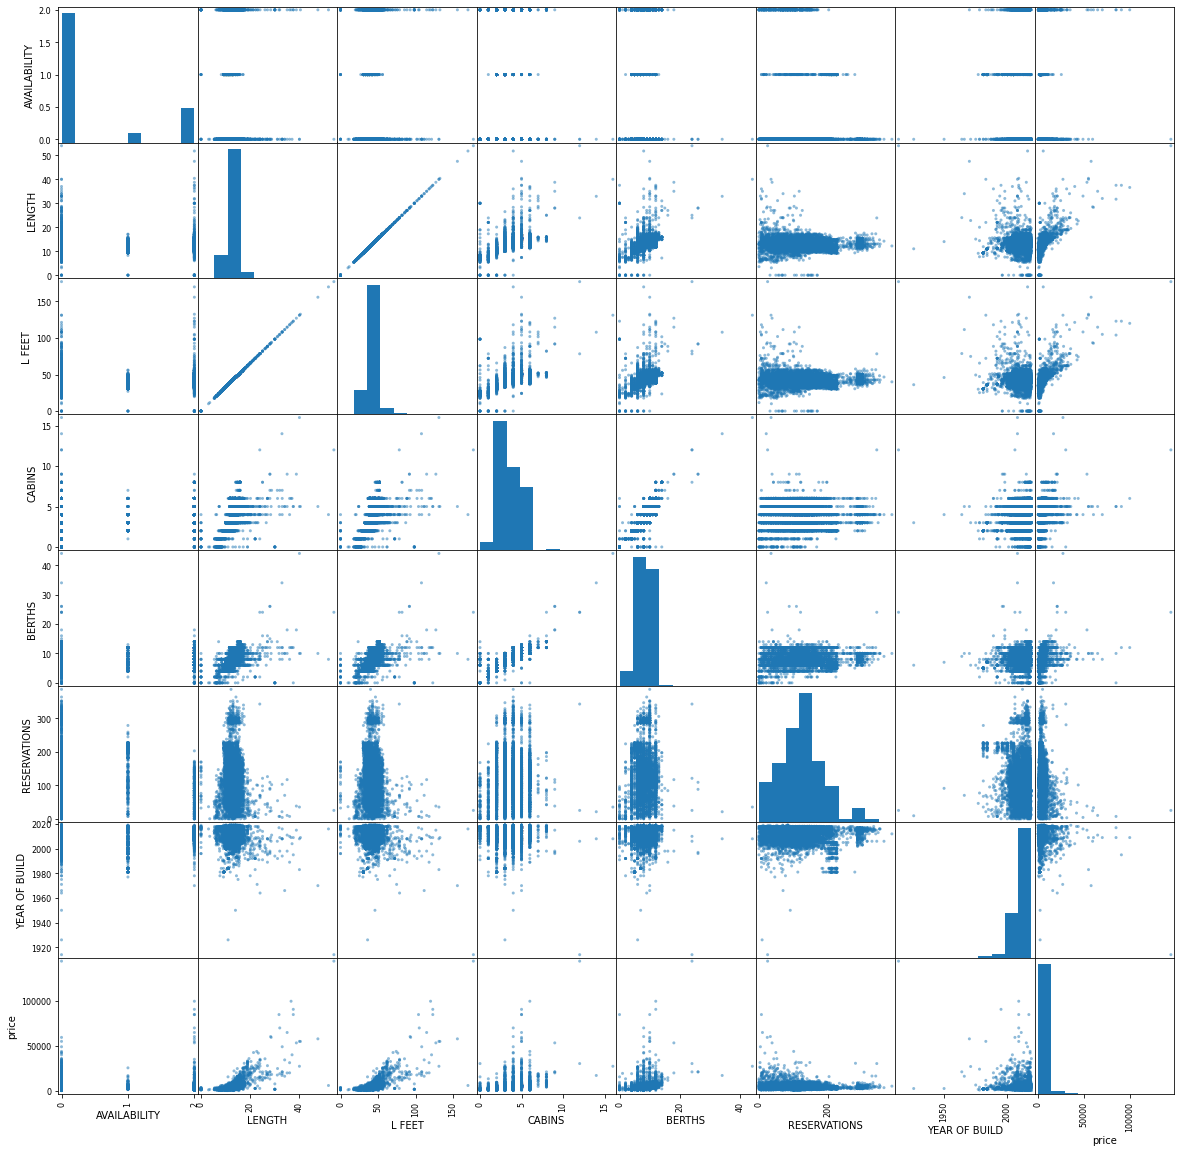

In [9]:
#Explore numerical features' correlation with average prices per peak season
boats_characteristics['price'] = pricesBoats.mean(axis=1)
num_features = ['AVAILABILITY', 'LENGTH', 'L FEET', 'CABINS', 'BERTHS', 'RESERVATIONS', 'YEAR OF BUILD', 'price']
pd.plotting.scatter_matrix(boats_characteristics[num_features], figsize=(20, 20))
plt.show()

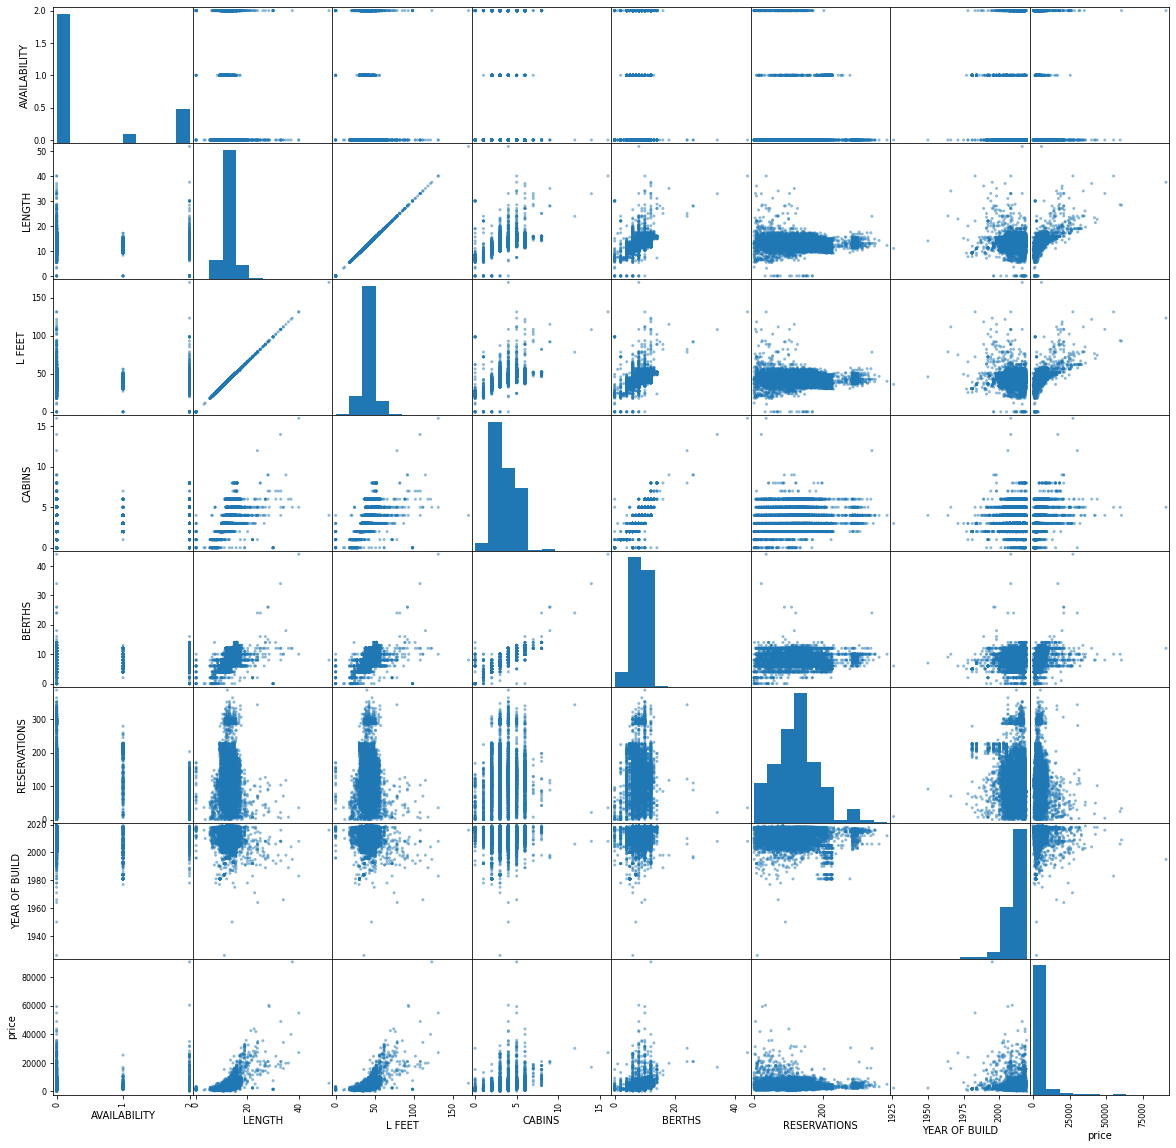

In [10]:
# Features' distributions are skewed and we also see outliers corresponding to each feature on scatter plots.
# Since we are going to use Lasso for a prediction, we need to get rid of outliers
# First, let's get rid of price outliers found in the previous step

boats_characteristics_without_price_outliers = boats_characteristics[(boats_characteristics['CHARTER NAME']!='Halas 71')&
      (boats_characteristics['CHARTER NAME']!='Claremont Yachting')&
      (boats_characteristics['CHARTER NAME']!='Cem Insaat')&
      (boats_characteristics['CHARTER NAME']!='Azalea Cruise')&
      (boats_characteristics['CHARTER NAME']!='Yacht Marine')]
len(boats_characteristics_without_price_outliers)

pd.plotting.scatter_matrix(boats_characteristics_without_price_outliers[num_features], figsize=(20, 20))
plt.show()

Number of models-outliers 169
Length of dataset without outliers: 7665


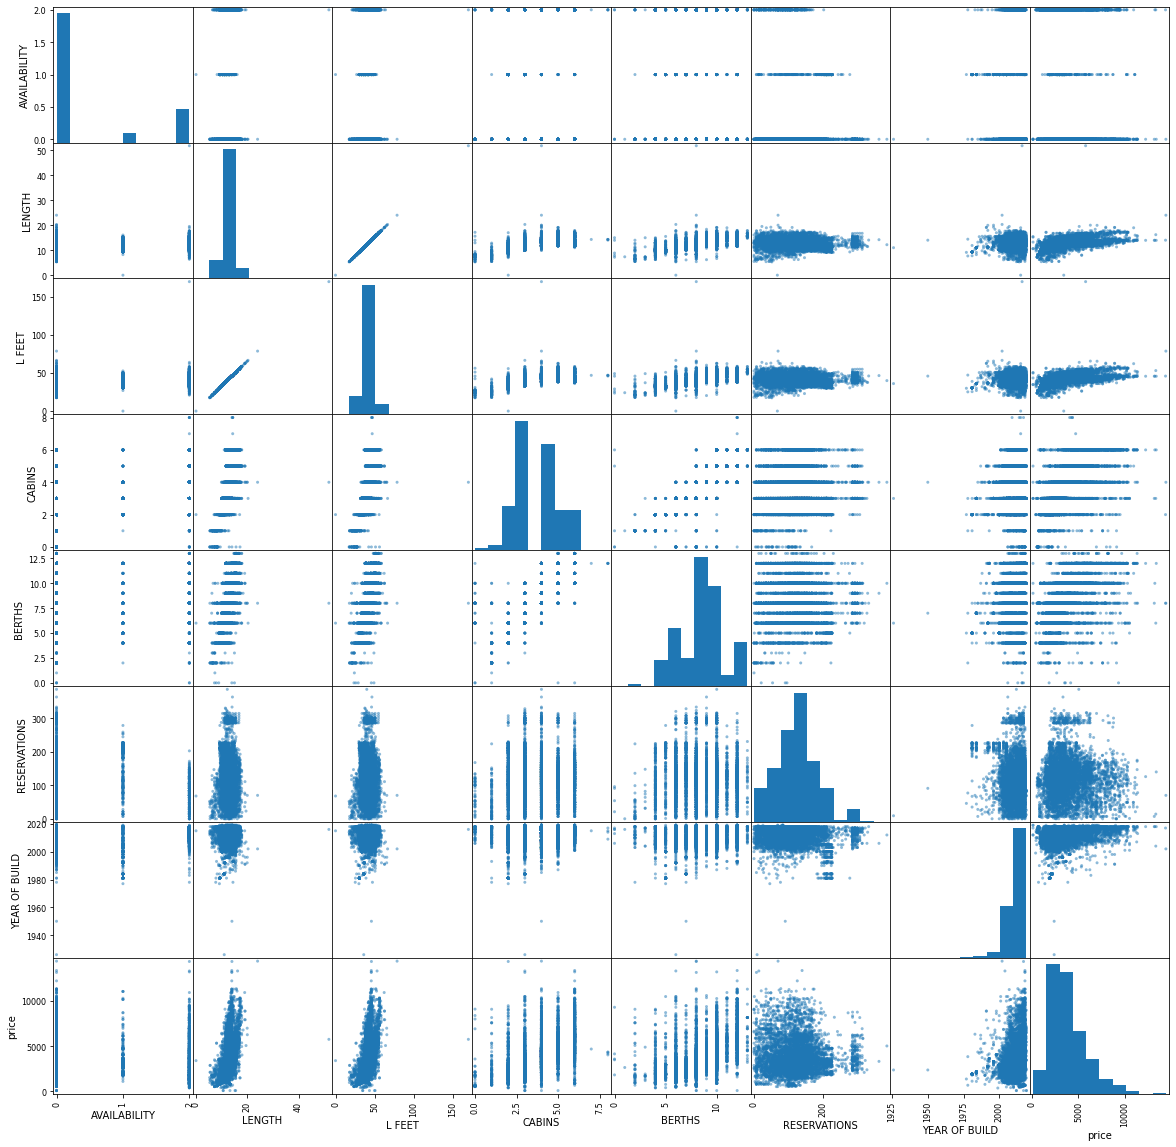

In [11]:
# It did not change the situation, so we can get rid of outliers in some of numerical features with Interquartile Range 
# "Year of build" outliers can be removed manually

# Let's detect the outliers among the models

boats_models = boats_characteristics.groupby('MODEL')[['LENGTH', 'L FEET', 'CABINS', 'BERTHS', 'RESERVATIONS', 'price']].mean().reset_index()

Q1 = boats_models[['LENGTH', 'L FEET', 'CABINS', 'BERTHS', 'RESERVATIONS', 'price']].quantile(0.25)
Q3 = boats_models[['LENGTH', 'L FEET', 'CABINS', 'BERTHS', 'RESERVATIONS', 'price']].quantile(0.75)
IQR = Q3 - Q1

l_out = boats_models[(boats_models['LENGTH']<(Q1[0]-1.5 * IQR[0])) | (boats_models['LENGTH']>(Q3[0]+1.5 * IQR[0]))]['MODEL'].unique()
l_f_out = boats_models[(boats_models['L FEET']<(Q1[1]-1.5 * IQR[1])) | (boats_models['L FEET']>(Q3[1]+1.5 * IQR[1]))]['MODEL'].unique()
c_out = boats_models[(boats_models['CABINS']<(Q1[2]-1.5 * IQR[2])) | (boats_models['CABINS']>(Q3[2]+1.5 * IQR[2]))]['MODEL'].unique()
b_out = boats_models[(boats_models['BERTHS']<(Q1[3]-1.5 * IQR[3])) | (boats_models['BERTHS']>(Q3[3]+1.5 * IQR[3]))]['MODEL'].unique()
r_out = boats_models[(boats_models['RESERVATIONS']<(Q1[5]-1.5 * IQR[5])) | (boats_models['RESERVATIONS']>(Q3[4]+1.5 * IQR[4]))]['MODEL'].unique()
p_out = boats_models[(boats_models['price']<(Q1[5]-1.5 * IQR[5])) | (boats_models['price']>(Q3[5]+1.5 * IQR[5]))]['MODEL'].unique()

models_out = set(l_out).union(set(l_f_out)).union(set(c_out)).union(set(b_out)).union(set(r_out)).union(set(p_out))
print('Number of models-outliers', len(models_out))

boats_characteristics_without_outliers = boats_characteristics[boats_characteristics['MODEL'].apply(lambda l: l not in models_out)]
print('Length of dataset without outliers:', len(boats_characteristics_without_outliers))

pd.plotting.scatter_matrix(boats_characteristics_without_outliers[num_features], figsize=(20, 20))
plt.show()

In [12]:
#Remove "year of build" outliers manually 
boats_characteristics_without_outliers = boats_characteristics_without_outliers[(boats_characteristics_without_outliers['YEAR OF BUILD']!=1950) & (boats_characteristics_without_outliers['YEAR OF BUILD']!=1925)]

#Explore observations which still have large length and l feet 
boats_characteristics_without_outliers[(boats_characteristics_without_outliers['LENGTH']>40) |
                                       (boats_characteristics_without_outliers['L FEET']>150)]

CHARTER ID  AVAILABILITY  ... RESERVATIONS    price
4663        1828             2  ...          NaN  5766.45

[1 rows x 16 columns]

Length of dataset without outliers: 7663


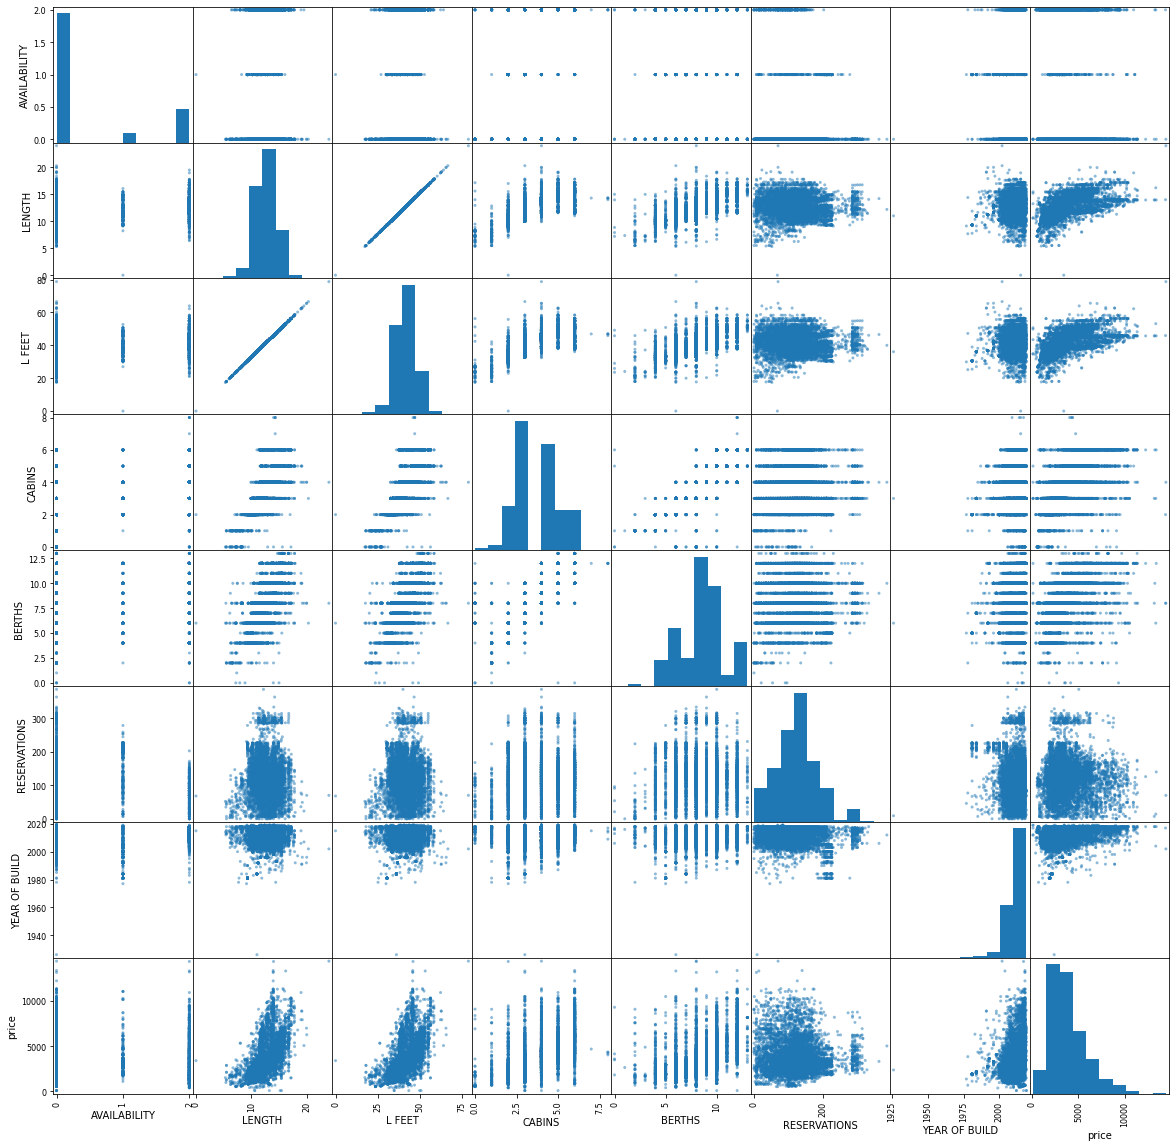

In [13]:
#Exclude it from the dataset without outliers
boats_characteristics_without_outliers = boats_characteristics_without_outliers[(boats_characteristics_without_outliers['LENGTH']<40)]
print('Length of dataset without outliers:', len(boats_characteristics_without_outliers))

pd.plotting.scatter_matrix(boats_characteristics_without_outliers[num_features], figsize=(20, 20))
plt.show()


In [14]:
#Explore categorical variables, number of unique categories
cat_features = ['CHARTER NAME','BRAND', 'MODEL', 'TYPE', 'BASE', 'COUNTRY', 'REGION']
boats_characteristics[cat_features].nunique()

CHARTER NAME     540
BRAND            125
MODEL           1056
TYPE               9
BASE             362
COUNTRY           47
REGION            58
dtype: int64

In [15]:
boats_characteristics = boats_characteristics.dropna()
boats_characteristics_without_outliers = boats_characteristics_without_outliers.dropna()
print(len(boats_characteristics))
print(len(boats_characteristics_without_outliers))

6264
5979


In [16]:
# Prepare data for training
# Use one-hot encoding for categorical features:
dummiesType = pd.get_dummies(boats_characteristics['TYPE']).rename(columns=lambda x: 'type_' + str(x))
dummiesBrand = pd.get_dummies(boats_characteristics['BRAND']).rename(columns=lambda x: 'brand_' + str(x))
dummiesModel = pd.get_dummies(boats_characteristics['MODEL']).rename(columns=lambda x: 'model_' + str(x))
#dummiesYear = pd.get_dummies(boats_characteristics['YEAR OF BUILD']).rename(columns=lambda x: 'year_' + str(x))
dummiesCountry = pd.get_dummies(boats_characteristics['COUNTRY']).rename(columns=lambda x: 'country_' + str(x))
dummiesBase = pd.get_dummies(boats_characteristics['BASE']).rename(columns=lambda x: 'base_' + str(x))
dummiesRegion = pd.get_dummies(boats_characteristics['REGION']).rename(columns=lambda x: 'region_' + str(x))
dummiesCharter = pd.get_dummies(boats_characteristics['CHARTER NAME']).rename(columns=lambda x: 'charter_' + str(x))

X = pd.DataFrame(pd.concat([boats_characteristics[num_features], dummiesType, 
                            dummiesBrand,dummiesModel,dummiesCountry,
                           dummiesBase, dummiesRegion, dummiesCharter], axis=1))
X = X.drop(columns=['price'])
y = boats_characteristics['price']
print(len(X.columns))

1840


In [17]:
# Prepare dataset without outliers for training 
dummiesType = pd.get_dummies(boats_characteristics_without_outliers['TYPE']).rename(columns=lambda x: 'type_' + str(x))
dummiesBrand = pd.get_dummies(boats_characteristics_without_outliers['BRAND']).rename(columns=lambda x: 'brand_' + str(x))
dummiesModel = pd.get_dummies(boats_characteristics_without_outliers['MODEL']).rename(columns=lambda x: 'model_' + str(x))
#dummiesYear = pd.get_dummies(boats_characteristics['YEAR OF BUILD']).rename(columns=lambda x: 'year_' + str(x))
dummiesCountry = pd.get_dummies(boats_characteristics_without_outliers['COUNTRY']).rename(columns=lambda x: 'country_' + str(x))
dummiesBase = pd.get_dummies(boats_characteristics_without_outliers['BASE']).rename(columns=lambda x: 'base_' + str(x))
dummiesRegion = pd.get_dummies(boats_characteristics_without_outliers['REGION']).rename(columns=lambda x: 'region_' + str(x))
dummiesCharter = pd.get_dummies(boats_characteristics_without_outliers['CHARTER NAME']).rename(columns=lambda x: 'charter_' + str(x))

X_without_out = pd.DataFrame(pd.concat([boats_characteristics_without_outliers[num_features], dummiesType, 
                            dummiesBrand,dummiesModel,dummiesCountry,
                           dummiesBase, dummiesRegion, dummiesCharter], axis=1))
X_without_out = X_without_out.drop(columns=['price'])
y_without_out = boats_characteristics['price']
print(len(X_without_out.columns))

1655


### Feature importance

In [18]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
import xgboost as xg
#First, we check that the model is working well on train and then we do feature importance
  
  
# Train set are converted to DMatrix objects, as it is required by learning API.
dmatrix = xg.DMatrix(data = X, label = y)

  
# Parameter dictionary specifying base learner
param = {"objective":"reg:squarederror"}
  
xgb_r = xg.train(params = param, dtrain = dmatrix, num_boost_round = 30)
pred = xgb_r.predict(dmatrix)
  
# RMSE Computation
rmse = np.sqrt(MSE(y, pred))
print("RMSE : % f" %(rmse))
r2 = r2_score(y,pred)
print("R2 : % f" %(r2))

RMSE :  613.551037
R2 :  0.977018


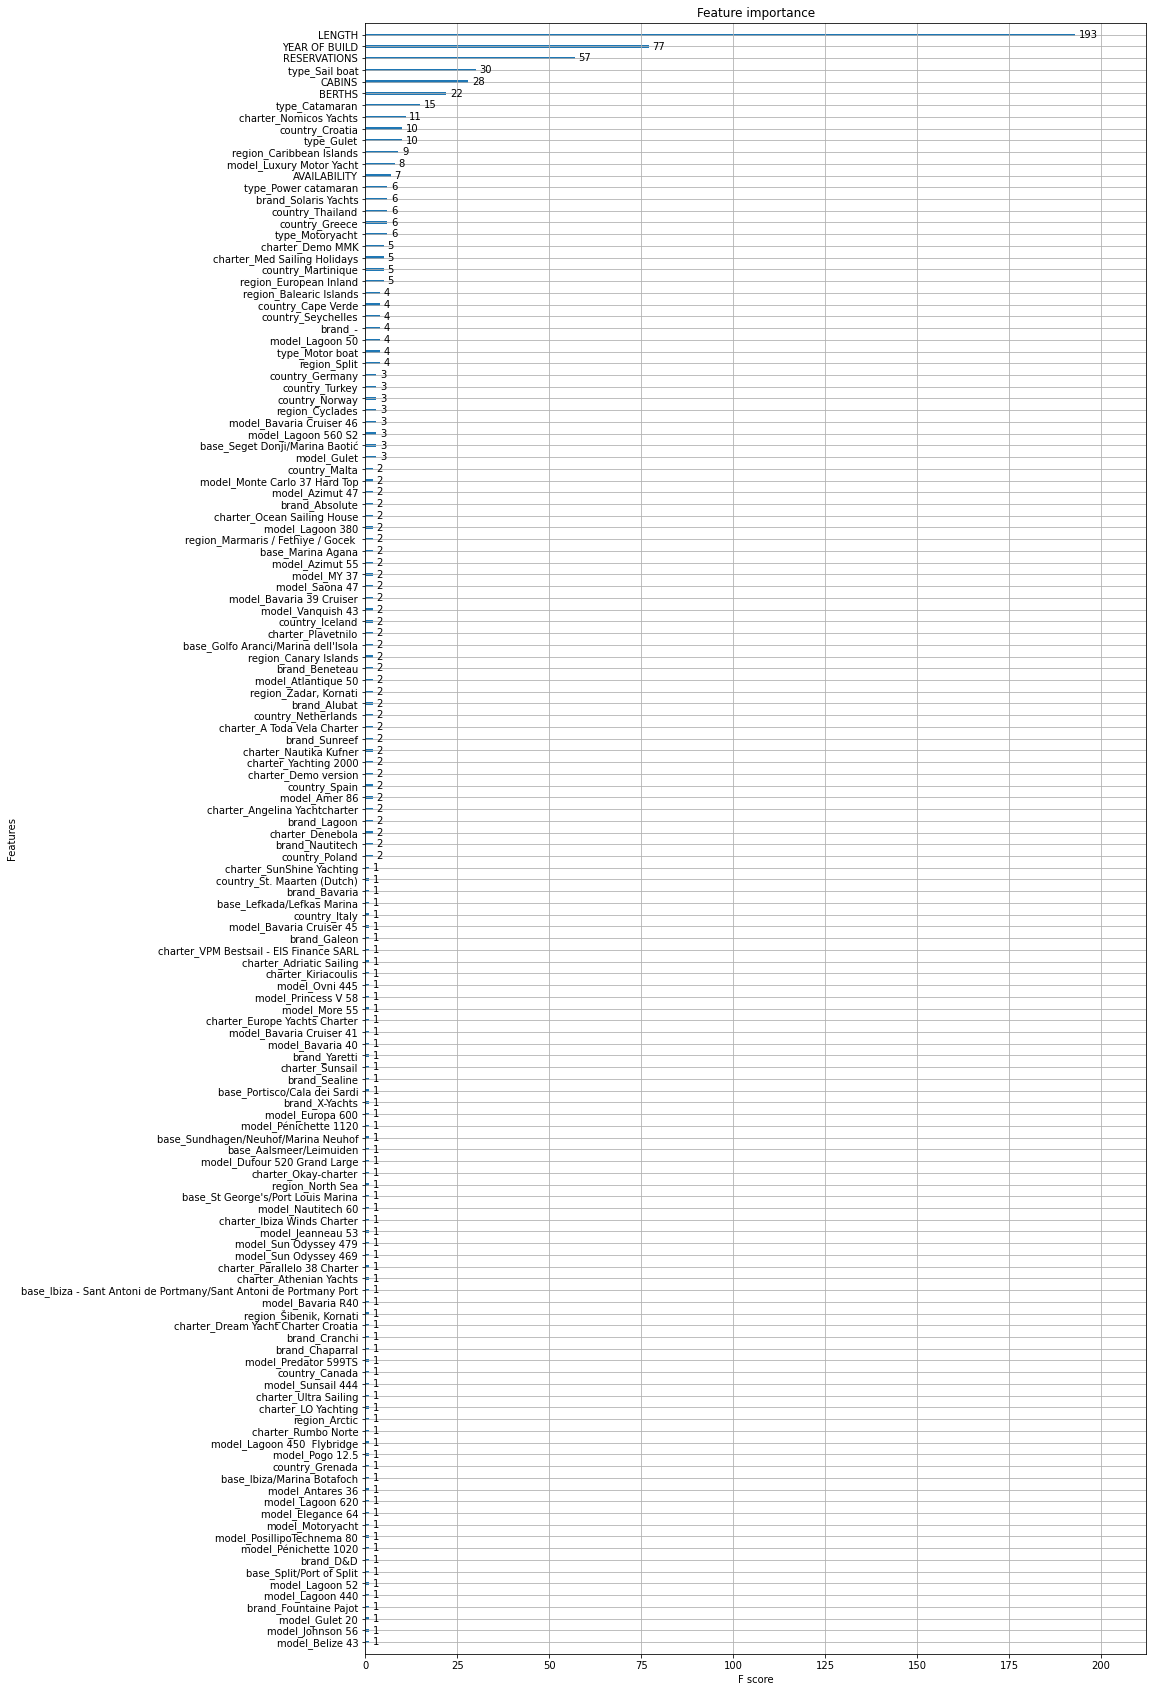

In [19]:
#Quality is ok, so we can do feature selection based on this model

from xgboost import plot_importance

feature_important = xgb_r.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
imp_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)


plt.rcParams["figure.figsize"] = (14, 30)
plot_importance(xgb_r)


In [147]:
important_features = list(imp_df[imp_df['score']>2].index)
X = X[important_features]
X_without_out = X_without_out[[x for x in list(X_without_out.columns) if x in important_features]]

In [164]:
from sklearn.svm import SVR

In [169]:
reg = SVR(kernel='rbf', C=100, epsilon=1)

reg.fit(X_train[important_features],y_train)

predicted = reg.predict(X_test[important_features])

In [171]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predicted))}")
print(f"R^2: {r2_score(y_test, predicted)}")

RMSE: 3055.3388604029687
R^2: -0.05834288381171593


# Regression of prices during most expensive week with some of the variables

In [ ]:
y1 = tableBoats3[["04.08.2018."]]

We know from the previous analysis that 04.08.2018. was the most expensive week. This will be our dependent variable. 

We transform some numerical variables that were of type OBJECT to FLOAT to be able to include those into the analysis. 

In [ ]:
tableBoats3 = tableBoats3.replace('-', np.nan)
tableBoats3['BERTHS'] = tableBoats3['BERTHS'].astype(float)
tableBoats3['CABINS'] = tableBoats3['CABINS'].astype(float)

Taking the squares and cubes if LENGTH, BERTHS and CABINS

In [ ]:
tableBoats3['LENGTH_sq'] = tableBoats3['LENGTH']**2
tableBoats3['BERTHS_sq'] = tableBoats3['BERTHS']**2
tableBoats3['CABINS_sq'] = tableBoats3['CABINS']**2
tableBoats3['LENGTH_cube'] = tableBoats3['LENGTH']**3
tableBoats3['BERTHS_cube'] = tableBoats3['BERTHS']**3
tableBoats3['CABINS_cube'] = tableBoats3['CABINS']**3

For now, we limit ourselves to 'AVAILABILITY','LENGTH','L FEET', 'BERTHS', 'CABINS' and 'RESERVATIONS' as these variables are numbers and can be directly used in a regression. 

In [ ]:
x1 = tableBoats3[['AVAILABILITY','LENGTH', 'LENGTH_sq', 'LENGTH_cube', 'RESERVATIONS','BERTHS', 'BERTHS_sq','BERTHS_cube','CABINS','CABINS_sq', 'CABINS_cube']]
X1 = sm.add_constant(x1)
X1.head()

const  AVAILABILITY  LENGTH  LENGTH_sq  LENGTH_cube  RESERVATIONS  \
CHARTER ID                                                                      
2996          1.0             0   15.38   236.5444  3638.052872         119.0   
800           1.0             2   15.75   248.0625  3906.984375         102.0   
1230          1.0             0   16.75   280.5625  4699.421875          49.0   
1856          1.0             2   11.70   136.8900  1601.613000           NaN   
2682          1.0             1   12.60   158.7600  2000.376000         213.0   

            BERTHS  BERTHS_sq  BERTHS_cube  CABINS  CABINS_sq  CABINS_cube  
CHARTER ID                                                                  
2996          10.0      100.0       1000.0     5.0       25.0        125.0  
800           12.0      144.0       1728.0     6.0       36.0        216.0  
1230           9.0       81.0        729.0     3.0        9.0         27.0  
1856           8.0       64.0        512.0     3.0        9.0         27.0  
2682          10.0      100.0       1000.0     3.0        9.0         27.0

In [ ]:
model1 = sm.OLS(y1,X1,missing='drop')
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:            04.08.2018.   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     826.3
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        04:24:40   Log-Likelihood:                -56828.
No. Observations:                6108   AIC:                         1.137e+05
Df Residuals:                    6096   BIC:                         1.138e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3047.8389    536.121      5.685   

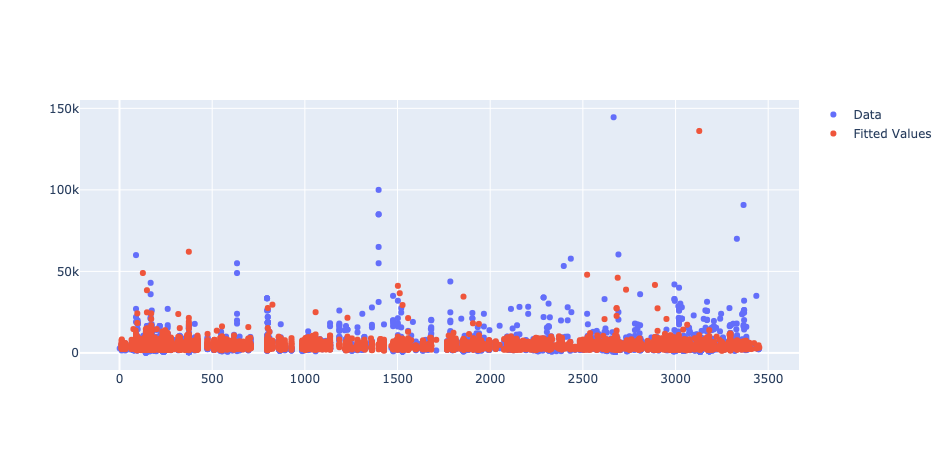

In [ ]:
trace1 = go.Scatter(
    x = tableBoats3.index,
    y = tableBoats3['04.08.2018.'],
    name = 'Data',
    mode = 'markers')
trace2 = go.Scatter(
    x = tableBoats3.index,
    y = results1.fittedvalues,
    name = 'Fitted Values',
    mode = 'markers')
data = [trace1, trace2]
fig = go.Figure(data=data)
fig.show()


## Correlation analysis of the features

In [ ]:
dfForCorrelations = tableBoats3[["04.08.2018.",'AVAILABILITY','LENGTH', 'LENGTH_sq', 'LENGTH_cube', 'RESERVATIONS','BERTHS_cube','CABINS','CABINS_sq', 'CABINS_cube']]

Current size: [6.0, 4.0]


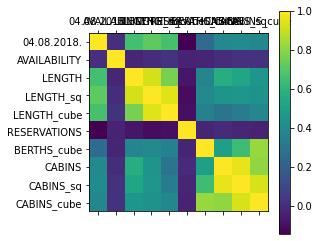

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
plt.matshow(dfForCorrelations .corr())
plt.xticks(range(len(dfForCorrelations .columns)), dfForCorrelations .columns)
plt.yticks(range(len(dfForCorrelations .columns)), dfForCorrelations .columns)
plt.colorbar()
fig_size[0] = 18
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size
plt.show()

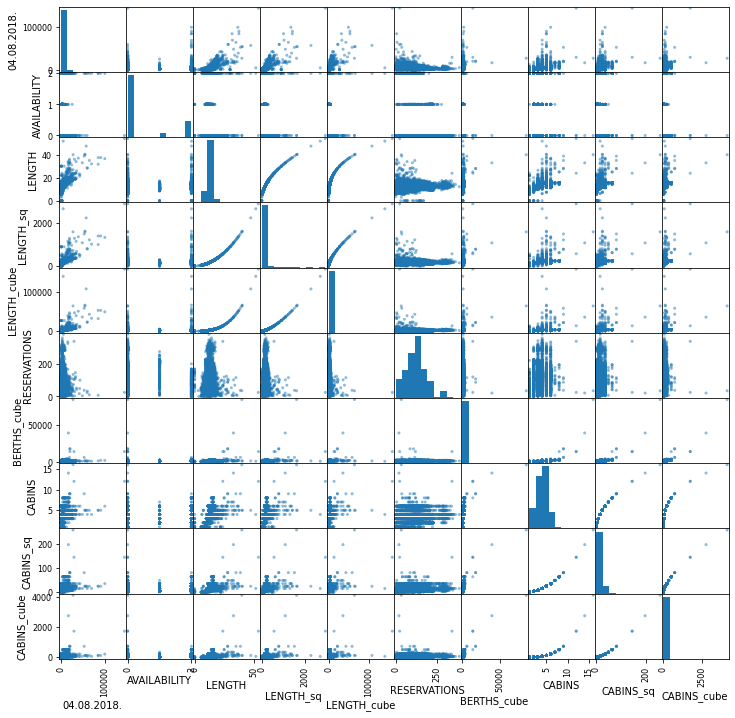

<Figure size 1296x1152 with 0 Axes>

In [ ]:
dataMeans = dfForCorrelations
pd.plotting.scatter_matrix(dataMeans, figsize=(12, 12))
plt.show()
plt.savefig('distribution_map')

In [ ]:
residuals1 = pd.DataFrame(results1.resid)

In [ ]:
dfForCorrelationResid = pd.DataFrame(dfForCorrelations.dropna())
dfForCorrelationResid = pd.DataFrame(dfForCorrelationResid.drop(['04.08.2018.'], axis =1))
dfForCorrelationResid = pd.concat([dfForCorrelationResid, residuals1], axis=1, sort=False)

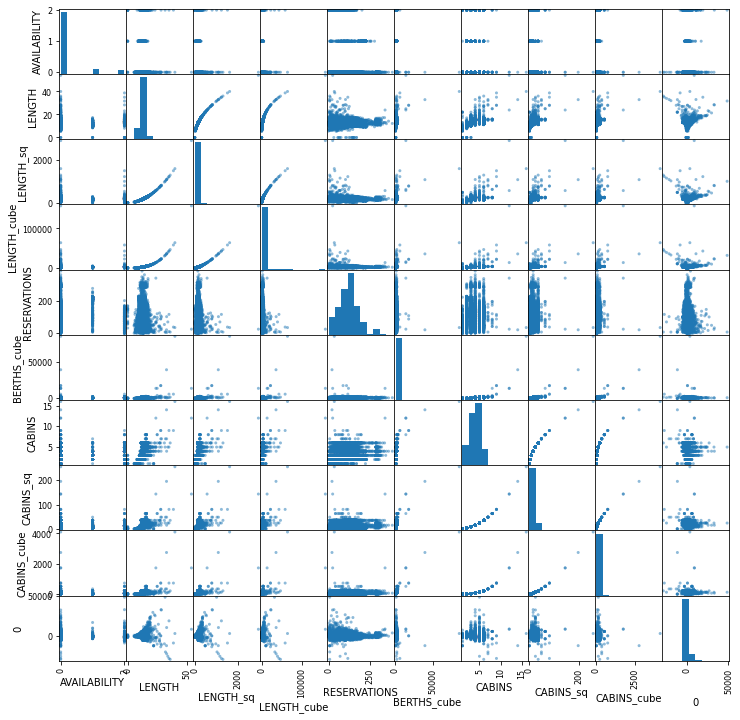

<Figure size 1296x1152 with 0 Axes>

In [ ]:
dataM = dfForCorrelationResid
pd.plotting.scatter_matrix(dfForCorrelationResid,figsize=(12, 12))
plt.show()
plt.savefig('distribution_map2')

Same thing without outliers. 

In [ ]:
tableBoats3NoOutliers = tableBoats3[(tableBoats3.BRAND != 'Catlante')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND != 'Leopard')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND != 'Pénichette')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND != 'Viko')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Sly')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Shipman')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Seawind')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Pershing')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Mondomarine')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='J')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Gemini')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Dominator')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Catana')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND !='Astondoa')]
tableBoats3NoOutliers = tableBoats3NoOutliers[(tableBoats3NoOutliers.BRAND != 'Astilleros')]

In [ ]:
tableBoats3NoOutliers = tableBoats3NoOutliers.replace('-', np.nan)
tableBoats3NoOutliers['BERTHS'] = tableBoats3NoOutliers['BERTHS'].astype(float)
tableBoats3NoOutliers['CABINS'] = tableBoats3NoOutliers['CABINS'].astype(float)

In [ ]:
tableBoats3NoOutliers['LENGTH_sq'] = tableBoats3NoOutliers['LENGTH']**2
tableBoats3NoOutliers['BERTHS_sq'] = tableBoats3NoOutliers['BERTHS']**2
tableBoats3NoOutliers['CABINS_sq'] = tableBoats3NoOutliers['CABINS']**2
tableBoats3NoOutliers['LENGTH_cube'] = tableBoats3NoOutliers['LENGTH']**3
tableBoats3NoOutliers['BERTHS_cube'] = tableBoats3NoOutliers['BERTHS']**3
tableBoats3NoOutliers['CABINS_cube'] = tableBoats3NoOutliers['CABINS']**3

In [ ]:
y1NoOutliers = tableBoats3NoOutliers[["04.08.2018."]]

In [ ]:
x1NoOutliers = tableBoats3NoOutliers[['AVAILABILITY','LENGTH', 'LENGTH_sq', 'LENGTH_cube', 'RESERVATIONS','BERTHS', 'BERTHS_sq','BERTHS_cube','CABINS','CABINS_sq', 'CABINS_cube']]
X1NoOutliers = sm.add_constant(x1NoOutliers)

In [ ]:
x1NoOutliers = tableBoats3NoOutliers[['AVAILABILITY','LENGTH', 'LENGTH_sq', 'LENGTH_cube', 'RESERVATIONS','BERTHS_cube','CABINS','CABINS_sq', 'CABINS_cube']]
X1NoOutliers = sm.add_constant(x1NoOutliers)

In [ ]:
model1NoOutliers = sm.OLS(y1NoOutliers,X1NoOutliers,missing='drop')
results1NoOutliers = model1NoOutliers.fit()
print(results1NoOutliers.summary())

                            OLS Regression Results                            
Dep. Variable:            04.08.2018.   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     947.2
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        04:29:09   Log-Likelihood:                -53962.
No. Observations:                5785   AIC:                         1.079e+05
Df Residuals:                    5775   BIC:                         1.080e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3044.4657    530.960      5.734   

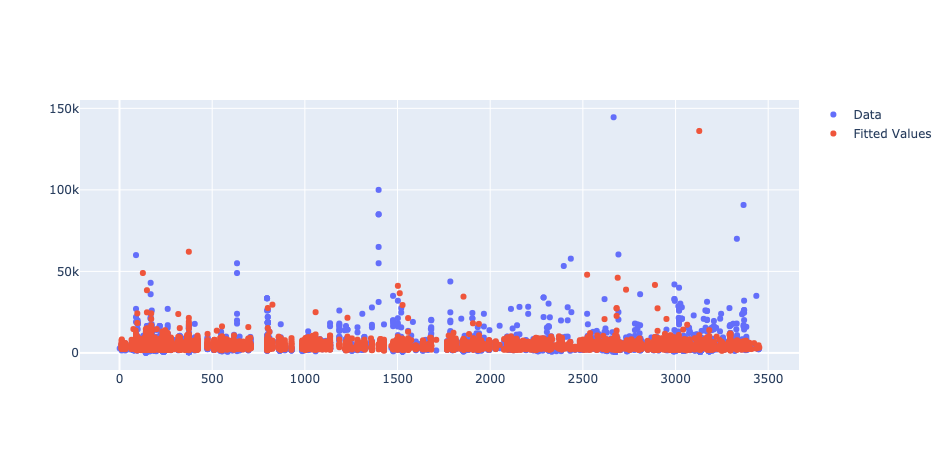

In [ ]:
trace1NoOutliers = go.Scatter(
    x = tableBoats3NoOutliers.index,
    y = tableBoats3NoOutliers['04.08.2018.'],
    name = 'Data',
    mode = 'markers')
trace2NoOutliers = go.Scatter(
    x = tableBoats3NoOutliers.index,
    y = results1NoOutliers.fittedvalues,
    name = 'Fitted Values',
    mode = 'markers')
dataNoOutliers = [trace1NoOutliers, trace2NoOutliers]
figNoOutliers = go.Figure(data=dataNoOutliers)
fig.show()


## Same regression using all the information available in the original data (with dummies)

Now want to include the other data that is available. Since these variables are non-numerical, we create dummies for each characteristic.

In [ ]:
dummiesType = pd.get_dummies(tableBoats3NoOutliers['TYPE']).rename(columns=lambda x: 'type_' + str(x))
dummiesBrand = pd.get_dummies(tableBoats3NoOutliers['BRAND']).rename(columns=lambda x: 'brand_' + str(x))
dummiesModel = pd.get_dummies(tableBoats3NoOutliers['MODEL']).rename(columns=lambda x: 'model_' + str(x))
dummiesYear = pd.get_dummies(tableBoats3NoOutliers['YEAR OF BUILD']).rename(columns=lambda x: 'year_' + str(x))
dummiesCountry = pd.get_dummies(tableBoats3NoOutliers['COUNTRY']).rename(columns=lambda x: 'country_' + str(x))
tableBoats_dummies1 = pd.DataFrame(pd.concat([tableBoats3NoOutliers, dummiesType, dummiesBrand,dummiesModel,dummiesYear,dummiesCountry], axis=1))
tableBoats_dummies1

We add the dummies to the dataframe and remove the original variables that we do not need anymore. 

In [ ]:
tableBoats_dummies1 = pd.DataFrame(pd.concat([tableBoats3NoOutliers, dummiesType, dummiesBrand,dummiesModel,dummiesYear,dummiesCountry], axis=1))
tableBoats_dummies1

AVAILABILITY           CHARTER NAME             YACHT ID  \
CHARTER ID                                                             
2996                   0        Athenian Yachts  1498666290000102996   
800                    2      Navigare Yachting     8605540397800800   
1230                   0         Sailing Sicily     6370110622601230   
1856                   2      Crouesty Location  1407877180000101856   
1996                   0              Sail Ways   783681070000101996   
...                  ...                    ...                  ...   
1523                   0         Surcando Mares   965874860000101523   
220                    0  Trend Travel Yachting     5787500524800220   
203                    0   Star Voyage Antilles   503697860000100203   
1520                   0            El Yachting     1388790462701520   
825                    2             Sailitalia   228886160000100825   

                       MODEL ID     BRAND               MODEL       TYPE  \
CHARTER ID                                                                 
2996        1498665010000102996  Jeanneau     Sun Odyssey 519  Sail boat   
800            8605440397800800  Jeanneau     Sun Odyssey 519  Sail boat   
1230           7630270644301230   Bavaria  Bavaria Cruiser 56  Sail boat   
1856        1407851690000101856   Feeling          Feeling 39  Sail boat   
1996            961100412401996  Jeanneau      Sun Odyssey 35  Sail boat   
...                         ...       ...                 ...        ...   
1523         965869960000101523   Bavaria          Bavaria 56  Sail boat   
220            5787250524800220  Jeanneau     Sun Odyssey 519  Sail boat   
203          123793880000100203  Jeanneau    Sun Odyssey 42 i  Sail boat   
1520           1388120462701520  Beneteau          Oceanis 46  Sail boat   
825          224070090000100825  Beneteau          Oceanis 37  Sail boat   

           YEAR OF BUILD  LENGTH  L FEET  ...  country_Spain  \
CHARTER ID                                ...                  
2996                2018   15.38   50.46  ...              0   
800                 2016   15.75   51.67  ...              0   
1230                2016   16.75   54.95  ...              0   
1856                2011   11.70   38.39  ...              0   
1996                2003   10.75   35.27  ...              0   
...                  ...     ...     ...  ...            ...   
1523                2015   16.75   54.95  ...              1   
220                 2017   15.75   51.67  ...              0   
203                 2011   12.85   42.16  ...              0   
1520                2009   14.09   46.23  ...              0   
825                 2010   11.48   37.66  ...              0   

            country_St. Lucia country_St. Maarten (Dutch)  \
CHARTER ID                                                  
2996                        0                           0   
800                         0                           0   
1230                        0                           0   
1856                        0                           0   
1996                        0                           0   
...                       ...                         ...   
1523                        0                           0   
220                         0                           0   
203                         0                           0   
1520                        0                           0   
825                         0                           0   

           country_St. Martin (French) country_St. Vincent and the Grenadines  \
CHARTER ID                                                                      
2996                                 0                                      0   
800                                  0                                      0   
1230                                 0                                      0   
1856                                 0                

In [ ]:
tableBoats3NoOutliers.index

Int64Index([2996,  800, 1230, 1856, 1996,  553,   12,  374,  870, 2889,
            ...
            1310,  406,  220,  609, 1237, 1523,  220,  203, 1520,  825],
           dtype='int64', name='CHARTER ID', length=7686)

In [ ]:
tableBoats_dummies = pd.DataFrame(tableBoats_dummies1.drop(['TYPE','BRAND','MODEL','YEAR OF BUILD','COUNTRY','REGION','BASE'], axis = 1))

In [ ]:
tableBoats_dummies = tableBoats_dummies.dropna()
tableBoats_dummies

AVAILABILITY            CHARTER NAME             YACHT ID  \
CHARTER ID                                                              
1909                   0         Istion Yachting   672400830000101909   
167                    0  Meridijan Yacht Servis     6971020324400167   
1939                   0  Sea Folk Yacht Charter   819251870000101939   
2497                   0   Golden Compass Yachts  1119361400000102497   
1909                   0         Istion Yachting   672409540000101909   
...                  ...                     ...                  ...   
220                    0   Trend Travel Yachting     3195080405100220   
609                    0       Marina & Yachting      342080160700609   
220                    0   Trend Travel Yachting     5787500524800220   
203                    0    Star Voyage Antilles   503697860000100203   
1520                   0             El Yachting     1388790462701520   

                       MODEL ID  LENGTH  L FEET  CABINS  BERTHS  RESERVATIONS  \
CHARTER ID                                                                      
1909         672300040000101909   13.95   45.77     4.0     8.0         151.0   
167            6970800324400167   13.47   44.19     6.0    12.0          89.0   
1939         819249550000101939   17.15   56.27     5.0    11.0         138.0   
2497        1119357150000102497   12.76   41.86     3.0     6.0         182.0   
1909         672302720000101909   13.30   43.63     4.0     8.0         139.0   
...                         ...     ...     ...     ...     ...           ...   
220          724824190000100220   11.95   39.21     6.0    10.0         108.0   
609             336050160700609   11.82   38.78     3.0     8.0          98.0   
220            5787250524800220   15.75   51.67     5.0    12.0          77.0   
203          123793880000100203   12.85   42.16     3.0     8.0         214.0   
1520           1388120462701520   14.09   46.23     4.0    10.0         140.0   

            30.12.2017.  ...  country_Spain  country_St. Lucia  \
CHARTER ID               ...                                     
1909             2300.0  ...              0                  0   
167              3400.0  ...              0                  0   
1939             4600.0  ...              0                  0   
2497             1957.0  ...              0                  0   
1909             1700.0  ...              0                  0   
...                 ...  ...            ...                ...   
220              1800.0  ...              0                  0   
609              1500.0  ...              0                  0   
220              2200.0  ...              0                  0   
203              3600.0  ...              0                  0   
1520             2200.0  ...              0                  0   

            country_St. Maarten (Dutch)  country_St. Martin (French)  \
CHARTER ID                                                             
1909                                  0                            0   
167                                   0                            0   
1939                                  0                            0   
2497                                  0                            0   
1909                                  0                            0   
...                                 ...                          ...   
220                                   0                            0   
609                                   0                            0   
220                                   0                            0   
203                                   0                            0   
1520                                  0                            0   

            country_St. Vincent and the Grenadines  country_Sweden  \
CHARTER ID                                                           
1909                                             0               0   
16

In [ ]:
y2 = tableBoats_dummies[["04.08.2018."]]
y2.head()

04.08.2018.
CHARTER ID             
1909             5300.0
167              8000.0
1939             8500.0
2497             4000.0
1909             3900.0

In [ ]:
tableBoats_dummies

AVAILABILITY            CHARTER NAME             YACHT ID  \
CHARTER ID                                                              
1909                   0         Istion Yachting   672400830000101909   
167                    0  Meridijan Yacht Servis     6971020324400167   
1939                   0  Sea Folk Yacht Charter   819251870000101939   
2497                   0   Golden Compass Yachts  1119361400000102497   
1909                   0         Istion Yachting   672409540000101909   
...                  ...                     ...                  ...   
220                    0   Trend Travel Yachting     3195080405100220   
609                    0       Marina & Yachting      342080160700609   
220                    0   Trend Travel Yachting     5787500524800220   
203                    0    Star Voyage Antilles   503697860000100203   
1520                   0             El Yachting     1388790462701520   

                       MODEL ID  LENGTH  L FEET  CABINS  BERTHS  RESERVATIONS  \
CHARTER ID                                                                      
1909         672300040000101909   13.95   45.77     4.0     8.0         151.0   
167            6970800324400167   13.47   44.19     6.0    12.0          89.0   
1939         819249550000101939   17.15   56.27     5.0    11.0         138.0   
2497        1119357150000102497   12.76   41.86     3.0     6.0         182.0   
1909         672302720000101909   13.30   43.63     4.0     8.0         139.0   
...                         ...     ...     ...     ...     ...           ...   
220          724824190000100220   11.95   39.21     6.0    10.0         108.0   
609             336050160700609   11.82   38.78     3.0     8.0          98.0   
220            5787250524800220   15.75   51.67     5.0    12.0          77.0   
203          123793880000100203   12.85   42.16     3.0     8.0         214.0   
1520           1388120462701520   14.09   46.23     4.0    10.0         140.0   

            30.12.2017.  ...  country_Spain  country_St. Lucia  \
CHARTER ID               ...                                     
1909             2300.0  ...              0                  0   
167              3400.0  ...              0                  0   
1939             4600.0  ...              0                  0   
2497             1957.0  ...              0                  0   
1909             1700.0  ...              0                  0   
...                 ...  ...            ...                ...   
220              1800.0  ...              0                  0   
609              1500.0  ...              0                  0   
220              2200.0  ...              0                  0   
203              3600.0  ...              0                  0   
1520             2200.0  ...              0                  0   

            country_St. Maarten (Dutch)  country_St. Martin (French)  \
CHARTER ID                                                             
1909                                  0                            0   
167                                   0                            0   
1939                                  0                            0   
2497                                  0                            0   
1909                                  0                            0   
...                                 ...                          ...   
220                                   0                            0   
609                                   0                            0   
220                                   0                            0   
203                                   0                            0   
1520                                  0                            0   

            country_St. Vincent and the Grenadines  country_Sweden  \
CHARTER ID                                                           
1909                                             0               0   
16

In [ ]:
x2 = tableBoats_dummies.iloc[:,np.r_[0,4,6:9,62:1286]]
X2 = sm.add_constant(x2)
X2.head()

const  AVAILABILITY  LENGTH  CABINS  BERTHS  RESERVATIONS  \
CHARTER ID                                                              
1909          1.0             0   13.95     4.0     8.0         151.0   
167           1.0             0   13.47     6.0    12.0          89.0   
1939          1.0             0   17.15     5.0    11.0         138.0   
2497          1.0             0   12.76     3.0     6.0         182.0   
1909          1.0             0   13.30     4.0     8.0         139.0   

            LENGTH_sq  BERTHS_sq  CABINS_sq  LENGTH_cube  ...  country_Spain  \
CHARTER ID                                                ...                  
1909         194.6025       64.0       16.0  2714.704875  ...              0   
167          181.4409      144.0       36.0  2444.008923  ...              0   
1939         294.1225      121.0       25.0  5044.200875  ...              0   
2497         162.8176       36.0        9.0  2077.552576  ...              0   
1909         176.8900       64.0       16.0  2352.637000  ...              0   

            country_St. Lucia  country_St. Maarten (Dutch)  \
CHARTER ID                                                   
1909                        0                            0   
167                         0                            0   
1939                        0                            0   
2497                        0                            0   
1909                        0                            0   

            country_St. Martin (French)  \
CHARTER ID                                
1909                                  0   
167                                   0   
1939                                  0   
2497                                  0   
1909                                  0   

            country_St. Vincent and the Grenadines  country_Sweden  \
CHARTER ID                                                           
1909                                             0               0   
167                                              0               0   
1939                                             0               0   
2497                                             0               0   
1909                                             0               0   

            country_Thailand  country_Turkey  country_U.S.A.  \
CHARTER ID                                                     
1909                       0               0               0   
167                        0               0               0   
1939                       0               0               0   
2497                       0               0               0   
1909                       0               0               0   

            country_United Kingdom  
CHARTER ID                          
1909                             0  
167                              0  
1939                             0  
2497                             0  
1909                             0  

[5 rows x 1230 columns]

In [ ]:
model2 = sm.OLS(y2,X2,missing='drop')
results2 = model2.fit()
print(results2.summary())

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning:

invalid value encountered in true_divide



                            OLS Regression Results                            
Dep. Variable:            04.08.2018.   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     71.35
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        04:29:56   Log-Likelihood:                -14753.
No. Observations:                1880   AIC:                         3.044e+04
Df Residuals:                    1411   BIC:                         3.304e+04
Df Model:                         468                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

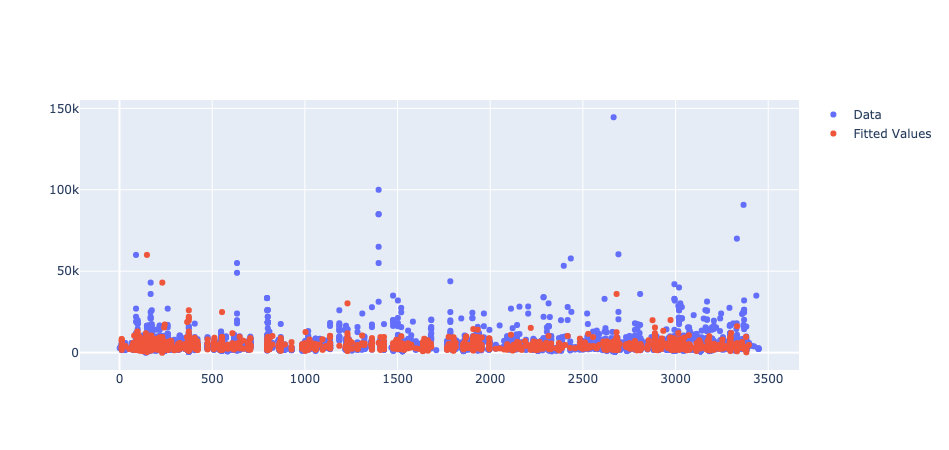

In [ ]:
trace3 = go.Scatter(
    x = tableBoats3.index,
    y = tableBoats3['04.08.2018.'],
    name = 'Data',
    mode = 'markers')
trace4 = go.Scatter(
    x = tableBoats3.index,
    y = results2.fittedvalues,
    name = 'Fitted Values',
    mode = 'markers')
data2 = [trace3, trace4]
fig2 = go.Figure(data=data2)
fig2.show()
#iplot(fig2, filename='simple-annotation')

## Create extra variables (interaction bt the variables ie LENGTHxTYPE, etc)

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# poly = PolynomialFeatures(interaction_only = True, include_bias = False)
# poly_x2 = poly.fit_transform(x2)

In [ ]:
# poly_X2 = sm.add_constant(poly_x2)

In [ ]:
# poly_model2 = sm.OLS(y2,poly_X2,missing='drop')
# poly_results2 = poly_model2.fit()
# print(poly_results2.summary())

Trying with a loop instead of package

In [ ]:
# x2.columns

# Lasso for model selection 

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X, y, test_size=0.3)

In [ ]:
lasso = Lasso()
lasso.fit(X_train_lasso, y_train_lasso)
train_score = lasso.score(X_train_lasso, y_train_lasso)
test_score = lasso.score(X_test_lasso, y_test_lasso)
coeff_used = np.sum(lasso.coef_ != 0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

training score: 0.7469435802340788
test score:  0.5931977436816616
number of features used:  34


In [ ]:
a = []
b = []
for i, j in zip(X.columns, lasso.coef_):
    if j !=0:
        a.append(i)
        b.append(j)
print(a, b)

['LENGTH', 'YEAR OF BUILD', 'RESERVATIONS', 'type_Sail boat', 'CABINS', 'BERTHS', 'type_Catamaran', 'charter_Nomicos Yachts', 'country_Croatia', 'type_Gulet', 'region_Caribbean Islands', 'model_Luxury Motor Yacht', 'AVAILABILITY', 'country_Thailand', 'country_Greece', 'type_Motoryacht', 'charter_Med Sailing Holidays', 'charter_Demo MMK', 'region_European Inland', 'region_Balearic Islands', 'model_Lagoon 50', 'brand_-', 'region_Split', 'country_Cape Verde', 'country_Seychelles', 'type_Motor boat', 'region_Cyclades', 'model_Lagoon 560 S2', 'country_Germany', 'country_Turkey', 'model_Bavaria Cruiser 46', 'base_Seget Donji/Marina Baotić', 'country_Norway', 'model_Gulet'] [1001.0564897170436, 97.06189693371782, -3.159086216691598, -5790.444455309636, -226.24291010866375, -110.92842780402529, -1362.474981761223, -2401.288208968304, -0.46161326425277516, -3612.117797700486, -3212.138504547385, 28517.076856519096, 444.11476035055637, -1791.3230531157137, 44.00841195142174, -1008.8523470599577,

In [ ]:
for feature, weight in zip(X.columns, lasso.coef_):
    print('{: <32} | {: <16.4f}'.format(feature, weight))

LENGTH                           | 1001.0565       
YEAR OF BUILD                    | 97.0619         
RESERVATIONS                     | -3.1591         
type_Sail boat                   | -5790.4445      
CABINS                           | -226.2429       
BERTHS                           | -110.9284       
type_Catamaran                   | -1362.4750      
charter_Nomicos Yachts           | -2401.2882      
country_Croatia                  | -0.4616         
type_Gulet                       | -3612.1178      
region_Caribbean Islands         | -3212.1385      
model_Luxury Motor Yacht         | 28517.0769      
AVAILABILITY                     | 444.1148        
country_Thailand                 | -1791.3231      
country_Greece                   | 44.0084         
brand_Solaris Yachts             | 0.0000          
type_Motoryacht                  | -1008.8523      
type_Power catamaran             | -0.0000         
charter_Med Sailing Holidays     | -2632.2664      
charter_Demo

In [ ]:
c = []
for i in range(len(a)):
    c.append((a[i], b[i]))
c.sort(key=lambda k: k[1], reverse=True)
c

[('model_Luxury Motor Yacht', 28517.076856519096),
 ('model_Lagoon 560 S2', 10649.611735089109),
 ('model_Lagoon 50', 3215.7472118853902),
 ('region_Cyclades', 1607.1970261704469),
 ('brand_-', 1012.4827441149384),
 ('LENGTH', 1001.0564897170436),
 ('country_Norway', 483.2352835991113),
 ('AVAILABILITY', 444.11476035055637),
 ('region_Balearic Islands', 425.7713310018187),
 ('base_Seget Donji/Marina Baotić', 376.60480441659286),
 ('region_Split', 199.83038140308082),
 ('YEAR OF BUILD', 97.06189693371782),
 ('country_Greece', 44.00841195142174),
 ('country_Croatia', -0.46161326425277516),
 ('RESERVATIONS', -3.159086216691598),
 ('BERTHS', -110.92842780402529),
 ('CABINS', -226.24291010866375),
 ('model_Bavaria Cruiser 46', -454.9229185078615),
 ('region_European Inland', -605.5766672726241),
 ('country_Turkey', -796.7760085050332),
 ('type_Motoryacht', -1008.8523470599577),
 ('country_Cape Verde', -1189.8491859095238),
 ('type_Catamaran', -1362.474981761223),
 ('country_Germany', -1468.

In [ ]:
len(c)

34

In [ ]:
d = []
f = []
for i in range(len(c)):
    d.append(c[i][0])
    f.append(c[i][1])

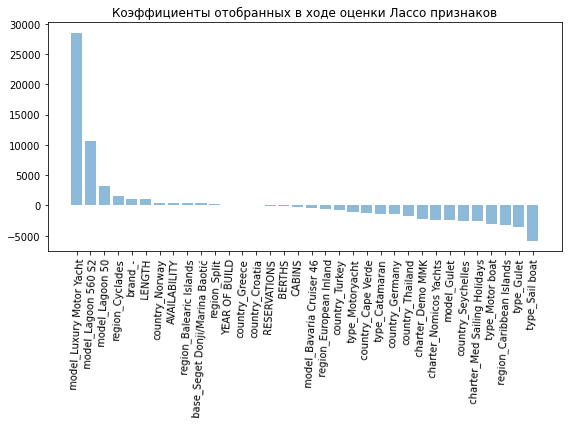

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(d, f, alpha=0.5, align='center', label = 'sd')
plt.title('Коэффициенты отобранных в ходе оценки Лассо признаков')
plt.xticks(rotation=87)
plt.tight_layout()
plt.show()

In [ ]:
lassofromCV = Lasso(alpha = 3702)
lassofromCV.fit(X2_train,y2_train)
train_scorefromCV = lassofromCV.score(X2_train,y2_train)
test_scorefromCV = lassofromCV.score(X2_test,y2_test)
coeff_usedfromCV = np.sum(lassofromCV.coef_ != 0)
print("training score:", train_scorefromCV)
print("test score: ", test_scorefromCV)
print("number of features used: ", coeff_usedfromCV)

training score: 0.5575996428407632
test score:  0.4012601243404498
number of features used:  5


In [ ]:
lasso136 = Lasso(alpha = 1.36, max_iter = 10e5)
lasso136.fit(X2_train,y2_train)
train_score136 = lasso136.score(X2_train,y2_train)
test_score136 = lasso136.score(X2_test,y2_test)
coeff_used136 = np.sum(lasso136.coef_ != 0)
print("training score for alpha=1.36:", train_score136)
print("test score for alpha =1.36: ", test_score136)
print("number of features used: for alpha =1.36:", coeff_used136)

training score for alpha=1.36: 0.9443146763575502
test score for alpha =1.36:  0.7996603678660179
number of features used: for alpha =1.36: 171


In [ ]:
lasso136Coef = pd.DataFrame(lasso136.coef_)

In [ ]:
lasso136Coef.index = X2.columns

In [ ]:
lasso136Coef.head()

0
const            0.000000
AVAILABILITY   668.245712
LENGTH        1220.999786
CABINS         175.795494
BERTHS         252.661704

    0.05 - Train R2 of 0.5247832119960272 and 429 features used
    1.00 - Train R2 of 0.5619605469765658 and 221 features used
    1.35 - Train R2 of 0.5632991319419731 and 191 features used
    1.36 - Train R2 of 0.5633089957343445 and 189 features used 
    1.37 - Train R2 of 0.5633074465419575 and 189 features used
    1.45 - Train R2 of 0.5631469877235922 and 185 features used

In [ ]:
lr = LinearRegression()
lr.fit(X2_train,y2_train)
lr_train_score = lr.score(X2_train,y2_train)
lr_test_score = lr.score(X2_test,y2_test)
print("LR training score:", lr_train_score) 
print("LR test score: ", lr_test_score)

LR training score: 0.9689395134460244
LR test score:  -273609348774339.4


In [ ]:
lassoCV = LassoCV(cv = 5)
result3 = lassoCV.fit(X2_train, y2_train['04.08.2018.'])
result3.alpha_

3997.720884952649

In [ ]:
result3Coef = pd.DataFrame(result3.coef_)
result3Coef.index = X2.columns
result3Coef[result3Coef != 0].head(10)

0
const               NaN
AVAILABILITY        NaN
LENGTH              NaN
CABINS              NaN
BERTHS              NaN
RESERVATIONS  -0.527997
LENGTH_sq    -18.090944
BERTHS_sq           NaN
CABINS_sq           NaN
LENGTH_cube    2.329978

In [ ]:
y2_predicted = lasso136.predict(X=X2_test)

In [ ]:
from sklearn.metrics import mean_squared_error

Text(0, 0.5, 'Predicted')

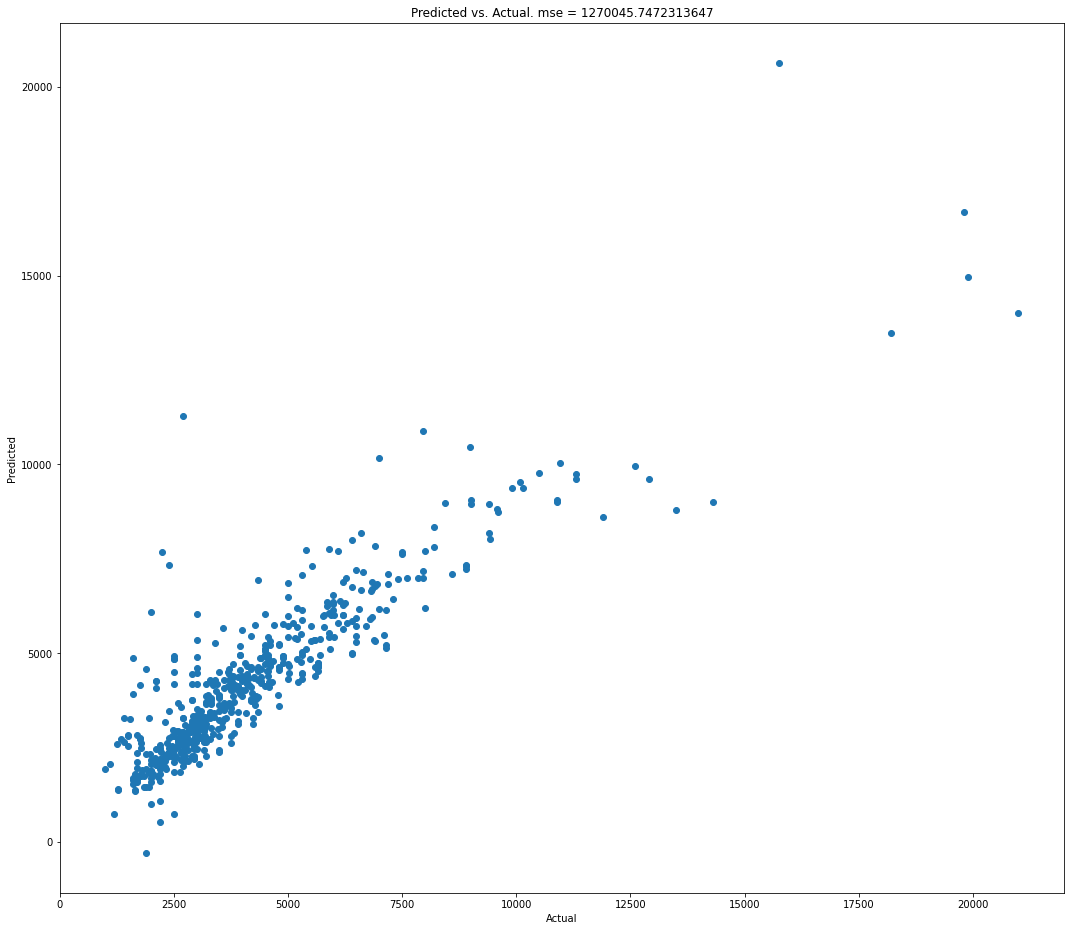

In [ ]:
plt.scatter(y2_test, y2_predicted)
mse = mean_squared_error(y2_test, y2_predicted)
plt.title(''.join(['Predicted vs. Actual.', ' mse = ', str(mse)]))
plt.xlabel('Actual')
plt.ylabel('Predicted')

We select the variables corresponding to non-zero coefficients from our Lasso regression. 

In [ ]:
lasso136Coef.head()

0
const            0.000000
AVAILABILITY   668.245712
LENGTH        1220.999786
CABINS         175.795494
BERTHS         252.661704

Now we can do a linear regression using only those variables kepts by the Lasso regression. 

In [ ]:
nonzeroCoef = lasso136Coef[lasso136Coef[0] != 0]
nonzeroCoef.head()

0
AVAILABILITY   668.245712
LENGTH        1220.999786
CABINS         175.795494
BERTHS         252.661704
RESERVATIONS     3.790833

In [ ]:
tableBoats_dummies.columns

Index(['AVAILABILITY', 'CHARTER NAME', 'YACHT ID', 'MODEL ID', 'LENGTH',
       'L FEET', 'CABINS', 'BERTHS', 'RESERVATIONS', '30.12.2017.',
       ...
       'country_Spain', 'country_St. Lucia', 'country_St. Maarten (Dutch)',
       'country_St. Martin (French)', 'country_St. Vincent and the Grenadines',
       'country_Sweden', 'country_Thailand', 'country_Turkey',
       'country_U.S.A.', 'country_United Kingdom'],
      dtype='object', length=1286)

In [ ]:
# selectedVar = tableBoats_dummies.where(tableBoats_dummies.columns == nonzeroCoef.index)

In [ ]:
y4 = tableBoats_dummies[["04.08.2018."]]
y4.head()

04.08.2018.
CHARTER ID             
1909             5300.0
167              8000.0
1939             8500.0
2497             4000.0
1909             3900.0

# Forecasting Prices

In [ ]:
pricesBoats3.columns

Index(['30.12.2017.', '06.01.2018.', '13.01.2018.', '20.01.2018.',
       '27.01.2018.', '03.02.2018.', '10.02.2018.', '17.02.2018.',
       '24.02.2018.', '03.03.2018.', '10.03.2018.', '17.03.2018.',
       '24.03.2018.', '31.03.2018.', '07.04.2018.', '14.04.2018.',
       '21.04.2018.', '28.04.2018.', '05.05.2018.', '12.05.2018.',
       '19.05.2018.', '26.05.2018.', '02.06.2018.', '09.06.2018.',
       '16.06.2018.', '23.06.2018.', '30.06.2018.', '07.07.2018.',
       '14.07.2018.', '21.07.2018.', '28.07.2018.', '04.08.2018.',
       '11.08.2018.', '18.08.2018.', '25.08.2018.', '01.09.2018.',
       '08.09.2018.', '15.09.2018.', '22.09.2018.', '29.09.2018.',
       '06.10.2018.', '13.10.2018.', '20.10.2018.', '27.10.2018.',
       '03.11.2018.', '10.11.2018.', '17.11.2018.', '24.11.2018.',
       '01.12.2018.', '08.12.2018.', '15.12.2018.', '22.12.2018.',
       '29.12.2018.'],
      dtype='object')

In [ ]:
forecastPrices = pricesBoats3
forecastPrices['mean'] = forecastPrices.mean(axis = 1, skipna = True)
forecastPricesMean = pd.DataFrame(forecastPrices['mean'])

In [ ]:
train = forecastPricesMean[0:45] 
test = forecastPricesMean[45:]

# Regression of reservations with the rest of the variables

In [ ]:
y3 = tableBoats_dummies[["RESERVATIONS"]]
y3.head()

RESERVATIONS
CHARTER ID              
1909               151.0
167                 89.0
1939               138.0
2497               182.0
1909               139.0

In [ ]:
tableBoats_dummies

AVAILABILITY            CHARTER NAME             YACHT ID  \
CHARTER ID                                                              
1909                   0         Istion Yachting   672400830000101909   
167                    0  Meridijan Yacht Servis     6971020324400167   
1939                   0  Sea Folk Yacht Charter   819251870000101939   
2497                   0   Golden Compass Yachts  1119361400000102497   
1909                   0         Istion Yachting   672409540000101909   
...                  ...                     ...                  ...   
220                    0   Trend Travel Yachting     3195080405100220   
609                    0       Marina & Yachting      342080160700609   
220                    0   Trend Travel Yachting     5787500524800220   
203                    0    Star Voyage Antilles   503697860000100203   
1520                   0             El Yachting     1388790462701520   

                       MODEL ID  LENGTH  L FEET  CABINS  BERTHS  RESERVATIONS  \
CHARTER ID                                                                      
1909         672300040000101909   13.95   45.77     4.0     8.0         151.0   
167            6970800324400167   13.47   44.19     6.0    12.0          89.0   
1939         819249550000101939   17.15   56.27     5.0    11.0         138.0   
2497        1119357150000102497   12.76   41.86     3.0     6.0         182.0   
1909         672302720000101909   13.30   43.63     4.0     8.0         139.0   
...                         ...     ...     ...     ...     ...           ...   
220          724824190000100220   11.95   39.21     6.0    10.0         108.0   
609             336050160700609   11.82   38.78     3.0     8.0          98.0   
220            5787250524800220   15.75   51.67     5.0    12.0          77.0   
203          123793880000100203   12.85   42.16     3.0     8.0         214.0   
1520           1388120462701520   14.09   46.23     4.0    10.0         140.0   

            30.12.2017.  ...  country_Spain  country_St. Lucia  \
CHARTER ID               ...                                     
1909             2300.0  ...              0                  0   
167              3400.0  ...              0                  0   
1939             4600.0  ...              0                  0   
2497             1957.0  ...              0                  0   
1909             1700.0  ...              0                  0   
...                 ...  ...            ...                ...   
220              1800.0  ...              0                  0   
609              1500.0  ...              0                  0   
220              2200.0  ...              0                  0   
203              3600.0  ...              0                  0   
1520             2200.0  ...              0                  0   

            country_St. Maarten (Dutch)  country_St. Martin (French)  \
CHARTER ID                                                             
1909                                  0                            0   
167                                   0                            0   
1939                                  0                            0   
2497                                  0                            0   
1909                                  0                            0   
...                                 ...                          ...   
220                                   0                            0   
609                                   0                            0   
220                                   0                            0   
203                                   0                            0   
1520                                  0                            0   

            country_St. Vincent and the Grenadines  country_Sweden  \
CHARTER ID                                                           
1909                                             0               0   
16

In [ ]:
# x3 = tableBoats_dummies.iloc[:,np.r_[0,4:8,10:1350]]
# X3 = sm.add_constant(x3)
# X3.head()

In [ ]:
# model3 = sm.OLS(y3,X3,missing='drop')
# results3 = model3.fit()
# print(results3.summary())

# XG Boost

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
# specifying baseline model

param = {"objective":"reg:squarederror"}
xgbr = xgb.XGBRegressor(params=param)

xgbr.fit(X_train,y_train)

preds = xgbr.predict(X_test)

In [ ]:
# results 
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds))}")
print(f"R^2: {r2_score(y_test, preds)}")

RMSE: 1450.619098
0.761430781404816


In [ ]:
# specifying some parameters 
# colsample_bytree, learning_rate preserve overfitting while increasing n_estimators

param = {"objective":"reg:squarederror",'colsample_bytree': 0.7,'learning_rate': 0.1, 'max_depth': 5, 'lambda': 10}

In [ ]:
xgbr = xgb.XGBRegressor(params=param , n_estimators = 1000)

xgbr.fit(X_train,y_train)

preds = xgbr.predict(X_test)

[09:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Compute the RMSE
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds))}")
print(f"R^2: {r2_score(y_test, preds)}")

RMSE: 1328.9812197358665
R^2: 0.7997625462823621


In [152]:
# let's try to do this on most important features found in previous steps

xgbr = xgb.XGBRegressor(params=param , n_estimators = 1000)

xgbr.fit(X_train[important_features],y_train)

preds = xgbr.predict(X_test[important_features])

[09:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [153]:
# Compute the RMSE
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds))}")
print(f"R^2: {r2_score(y_test, preds)}")

RMSE: 1302.0025320856244
R^2: 0.8078097799555215


In [159]:
# performing GridSearchCV to choose best parameters
xgbr = xgb.XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [0.1, 0.07],
              'max_depth': [3, 5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.4, 0.6, 0.8],
              'n_estimators': [1000],
              'gamma': [0, 0.03, 0.1, 0.3]}

xgb_grid = GridSearchCV(estimator=xgbr,
                        param_grid=parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train[important_features], y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
0.739835928577652
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [160]:
param = xgb_grid.best_params_

In [161]:
xg_reg = xgb.XGBRegressor(params=param , n_estimators = 1000)

xg_reg.fit(X_train[important_features],y_train)

pred = xg_reg.predict(X_test[important_features])

[09:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [163]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: %f" % (rmse))
print(f"R^2: {r2_score(y_test, pred)}")

RMSE: 1302.002532
R^2: 0.8078097799555215


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [ ]:
import xgboost as xgb

XGBoost Regressor 

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.2, learning_rate = 0.1,
                max_depth = 5, alpha = 1.36, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)
print(xg_reg)

[04:35:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(alpha=1.36, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=1.36000001,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [ ]:
y_pred = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 2243.752001


In [ ]:
regrxgb = xgb.XGBRegressor(
                colsample_bytree=0.2,
                gamma=0.0,
                learning_rate=0.01,
                max_depth=4,
                min_child_weight=1.5,
                n_estimators=7200,
                reg_alpha=0.9,
                reg_lambda=0.6,
                subsample=0.2,
                seed=42,
                silent=1)

In [ ]:
regrxgb.fit(X_train,y_train)
print(regrxgb)

XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4,
             min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9,
             reg_lambda=0.6, seed=42, silent=1, subsample=0.2)


In [ ]:
y_pred = regrxgb.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 1843.755139


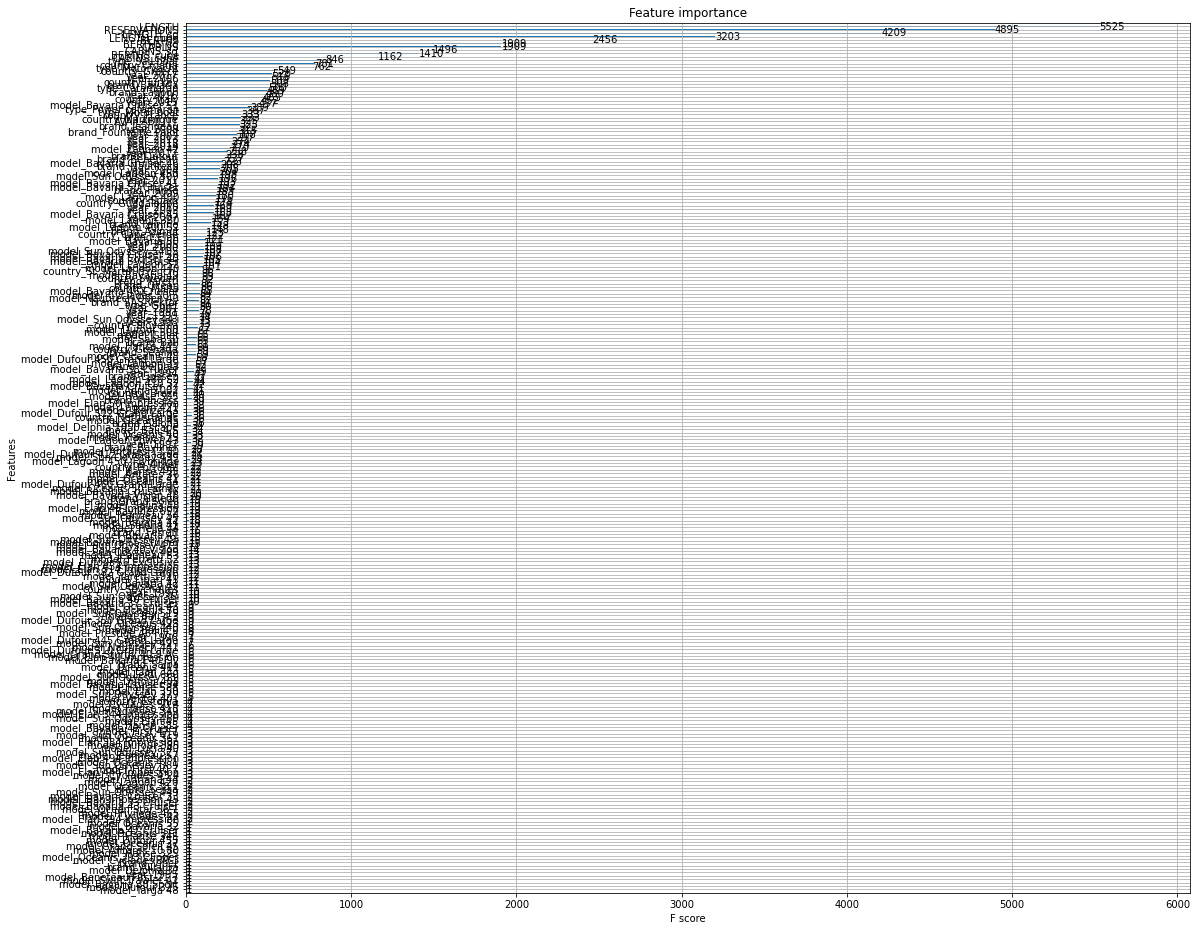

In [ ]:
xgb.plot_importance(regrxgb, importance_type= 'weight')
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

API

In [ ]:
DM_train = xgb.DMatrix(X_train, y_train)
DM_test = xgb.DMatrix(X_test, y_test)

In [ ]:
params1 = {'booster':'xgblinear','objective': 'reg:linear'}

In [ ]:
 #xg_reg2 = xgb.train(params = params1, dtrain = DM_train, num_boost_round=10)

In [ ]:
#y_pred2 = xg_reg2.predict(DM_test)

NameError: name 'xg_reg2' is not defined

In [ ]:
#rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
#rmse_norm = rmse / np.median(y_test)

In [ ]:
#print("RMSE: %f" % (rmse_norm))

XGBoost Cross-validation 

In [ ]:
params2 = {"objective":"reg:linear",'max_depth': 5}

In [ ]:
cv_results1 = xgb.cv(dtrain=DM_train, params=params2, nfold=4, 
                    num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

[04:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print((cv_results1["test-rmse-mean"]).tail(1))

4    2232.130005
Name: test-rmse-mean, dtype: float64


In [ ]:
l2_params = [0.6, 15]
rmses_l2=[]

In [ ]:
params2['alpha']=0.9

In [ ]:
for reg in l2_params:
    params2['lambda'] = reg
    cv_results2 = xgb.cv(dtrain = DM_train, params = params2, 
                        nfold = 4, num_boost_round = 10, metrics = 'rmse',
                        as_pandas= True, seed = 123)
    rmses_l2.append(cv_results2['test-rmse-mean'] \
                   .tail(1).values[0])

[04:37:40] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:40] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is no

In [ ]:
print('best rmse as function of l2:')

best rmse as function of l2:


In [ ]:
print(cv_results2.tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
9      1644.318604      154.650705     1906.880981     556.600965


In [ ]:
print(pd.DataFrame(list(zip(l2_params,rmses_l2)),columns=['l2','rmse']))

     l2         rmse
0   0.6  2000.738830
1  15.0  1906.880981


# Plots

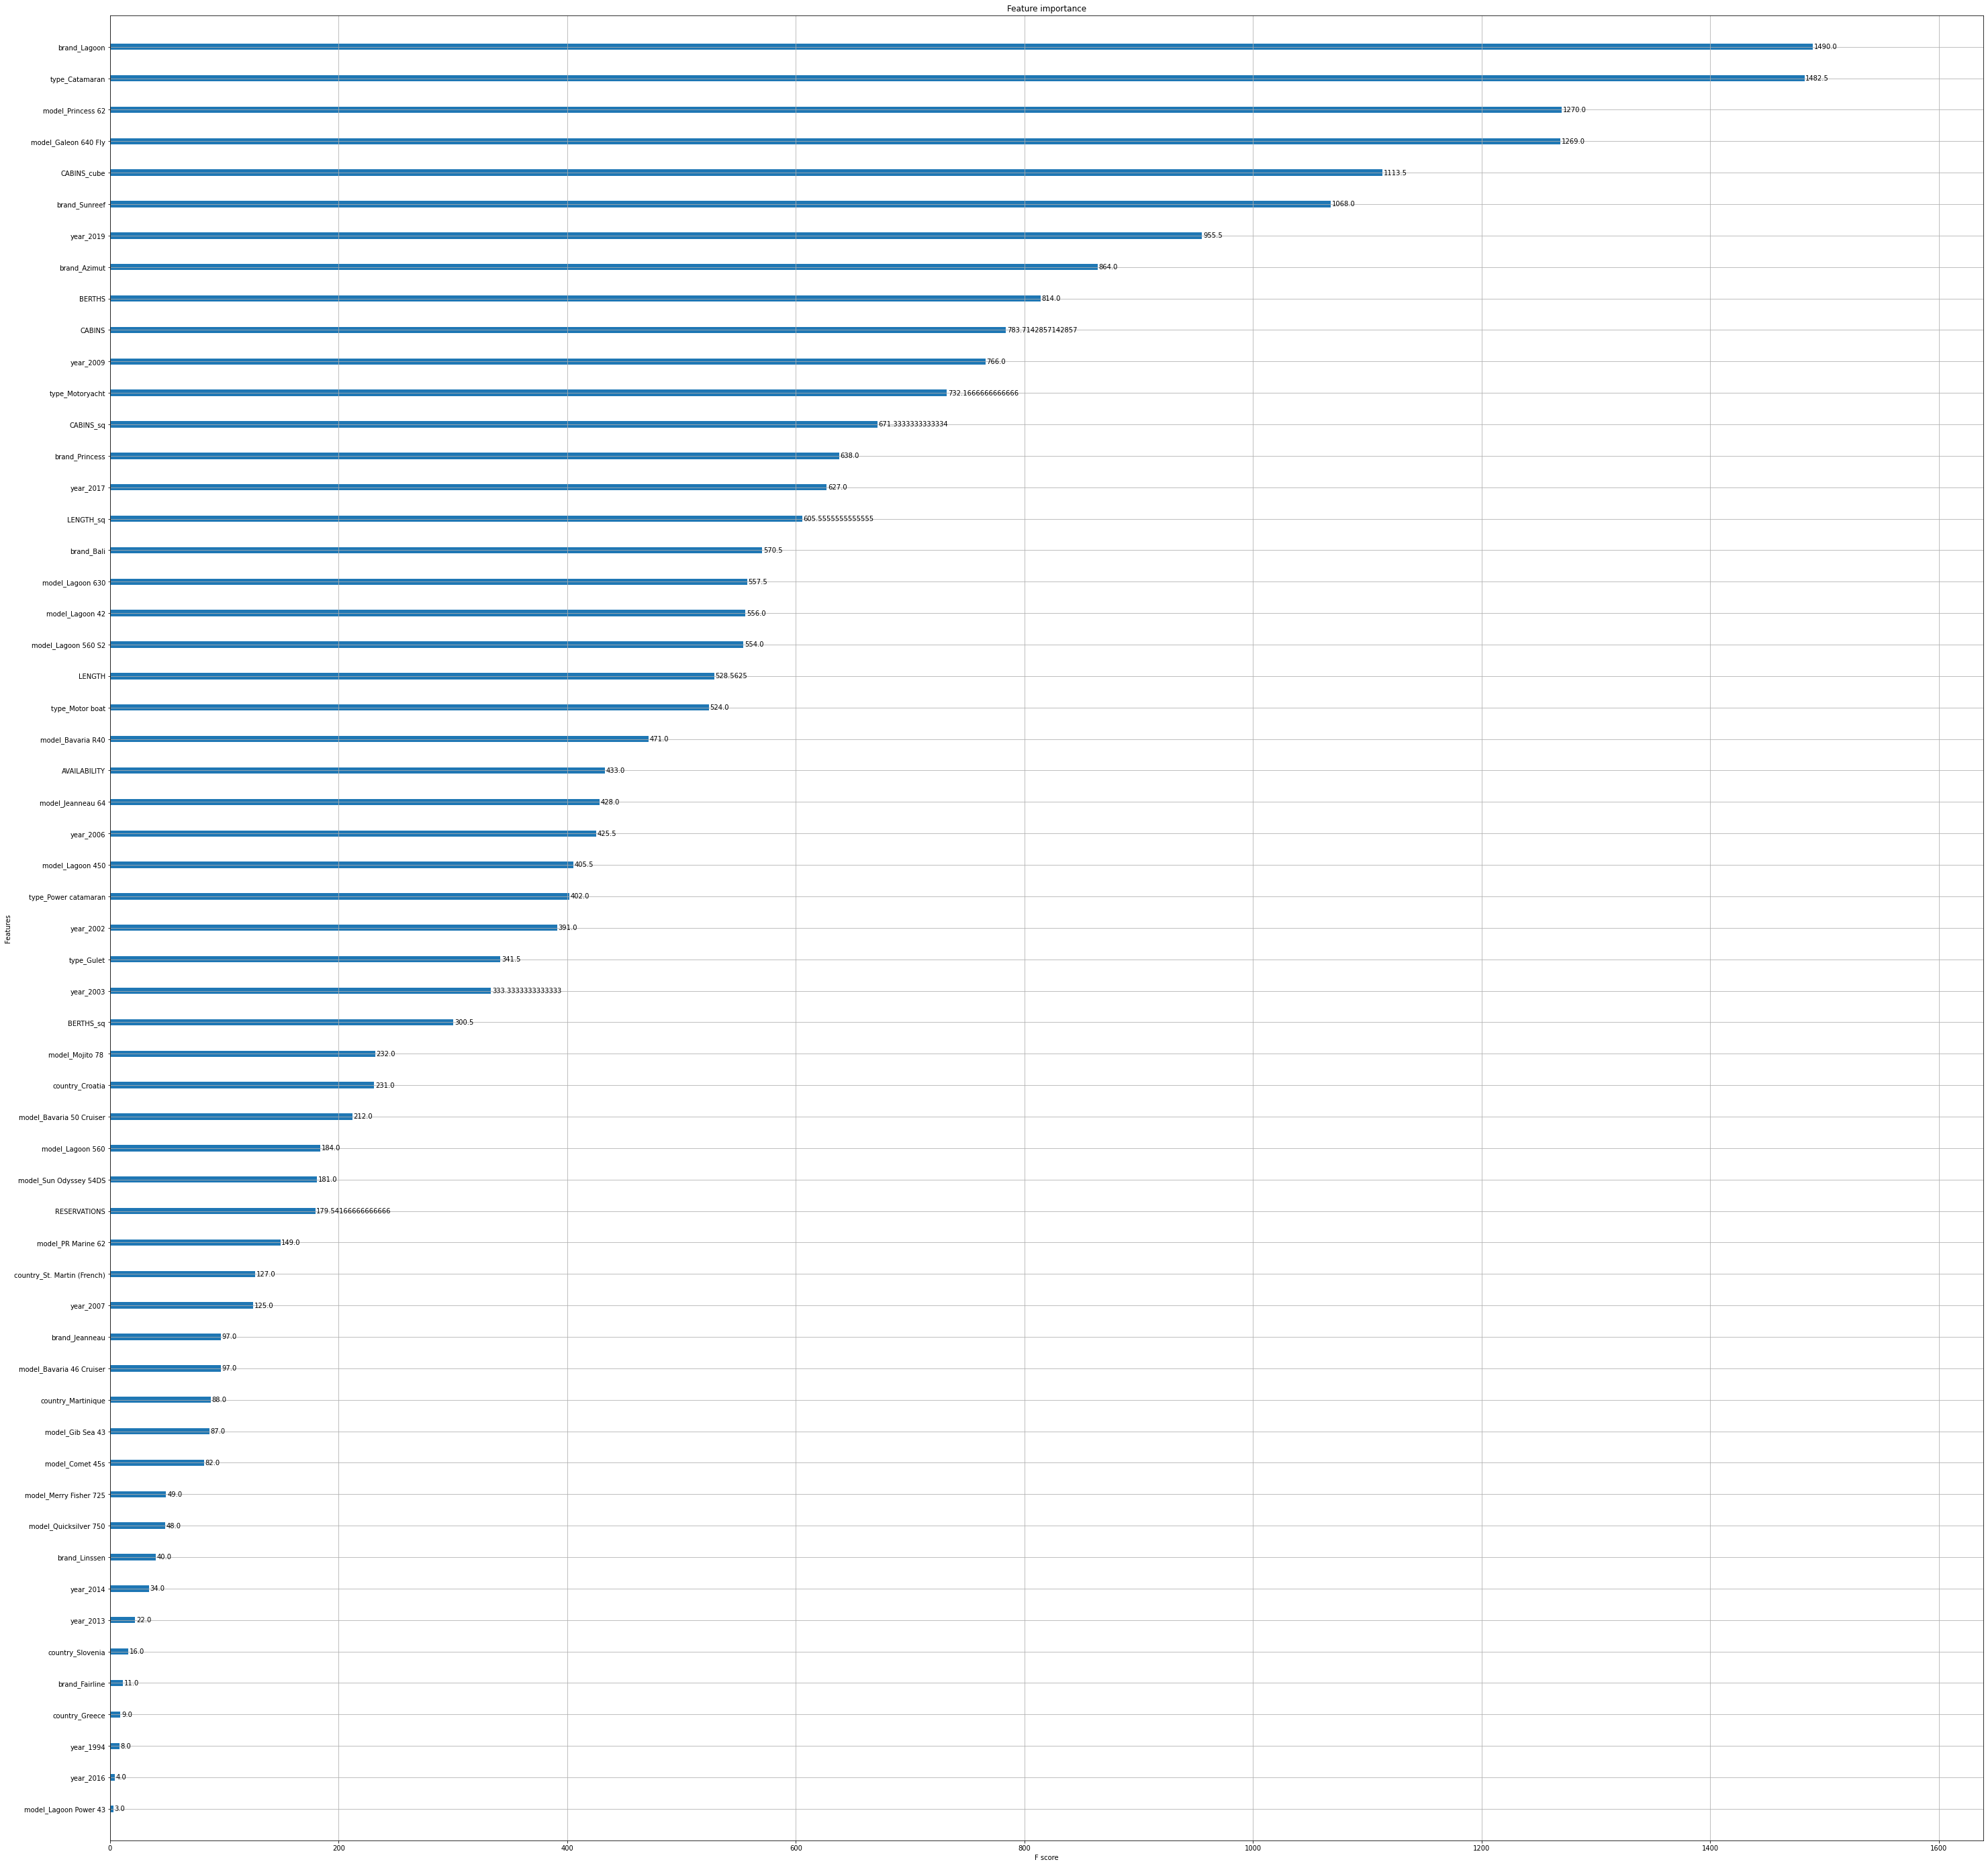

In [ ]:
# The number of times a feature is used to split the data across 
# all trees weighted by the number of training data points that go through those splits.
xgb.plot_importance(xg_reg, importance_type= 'cover')
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

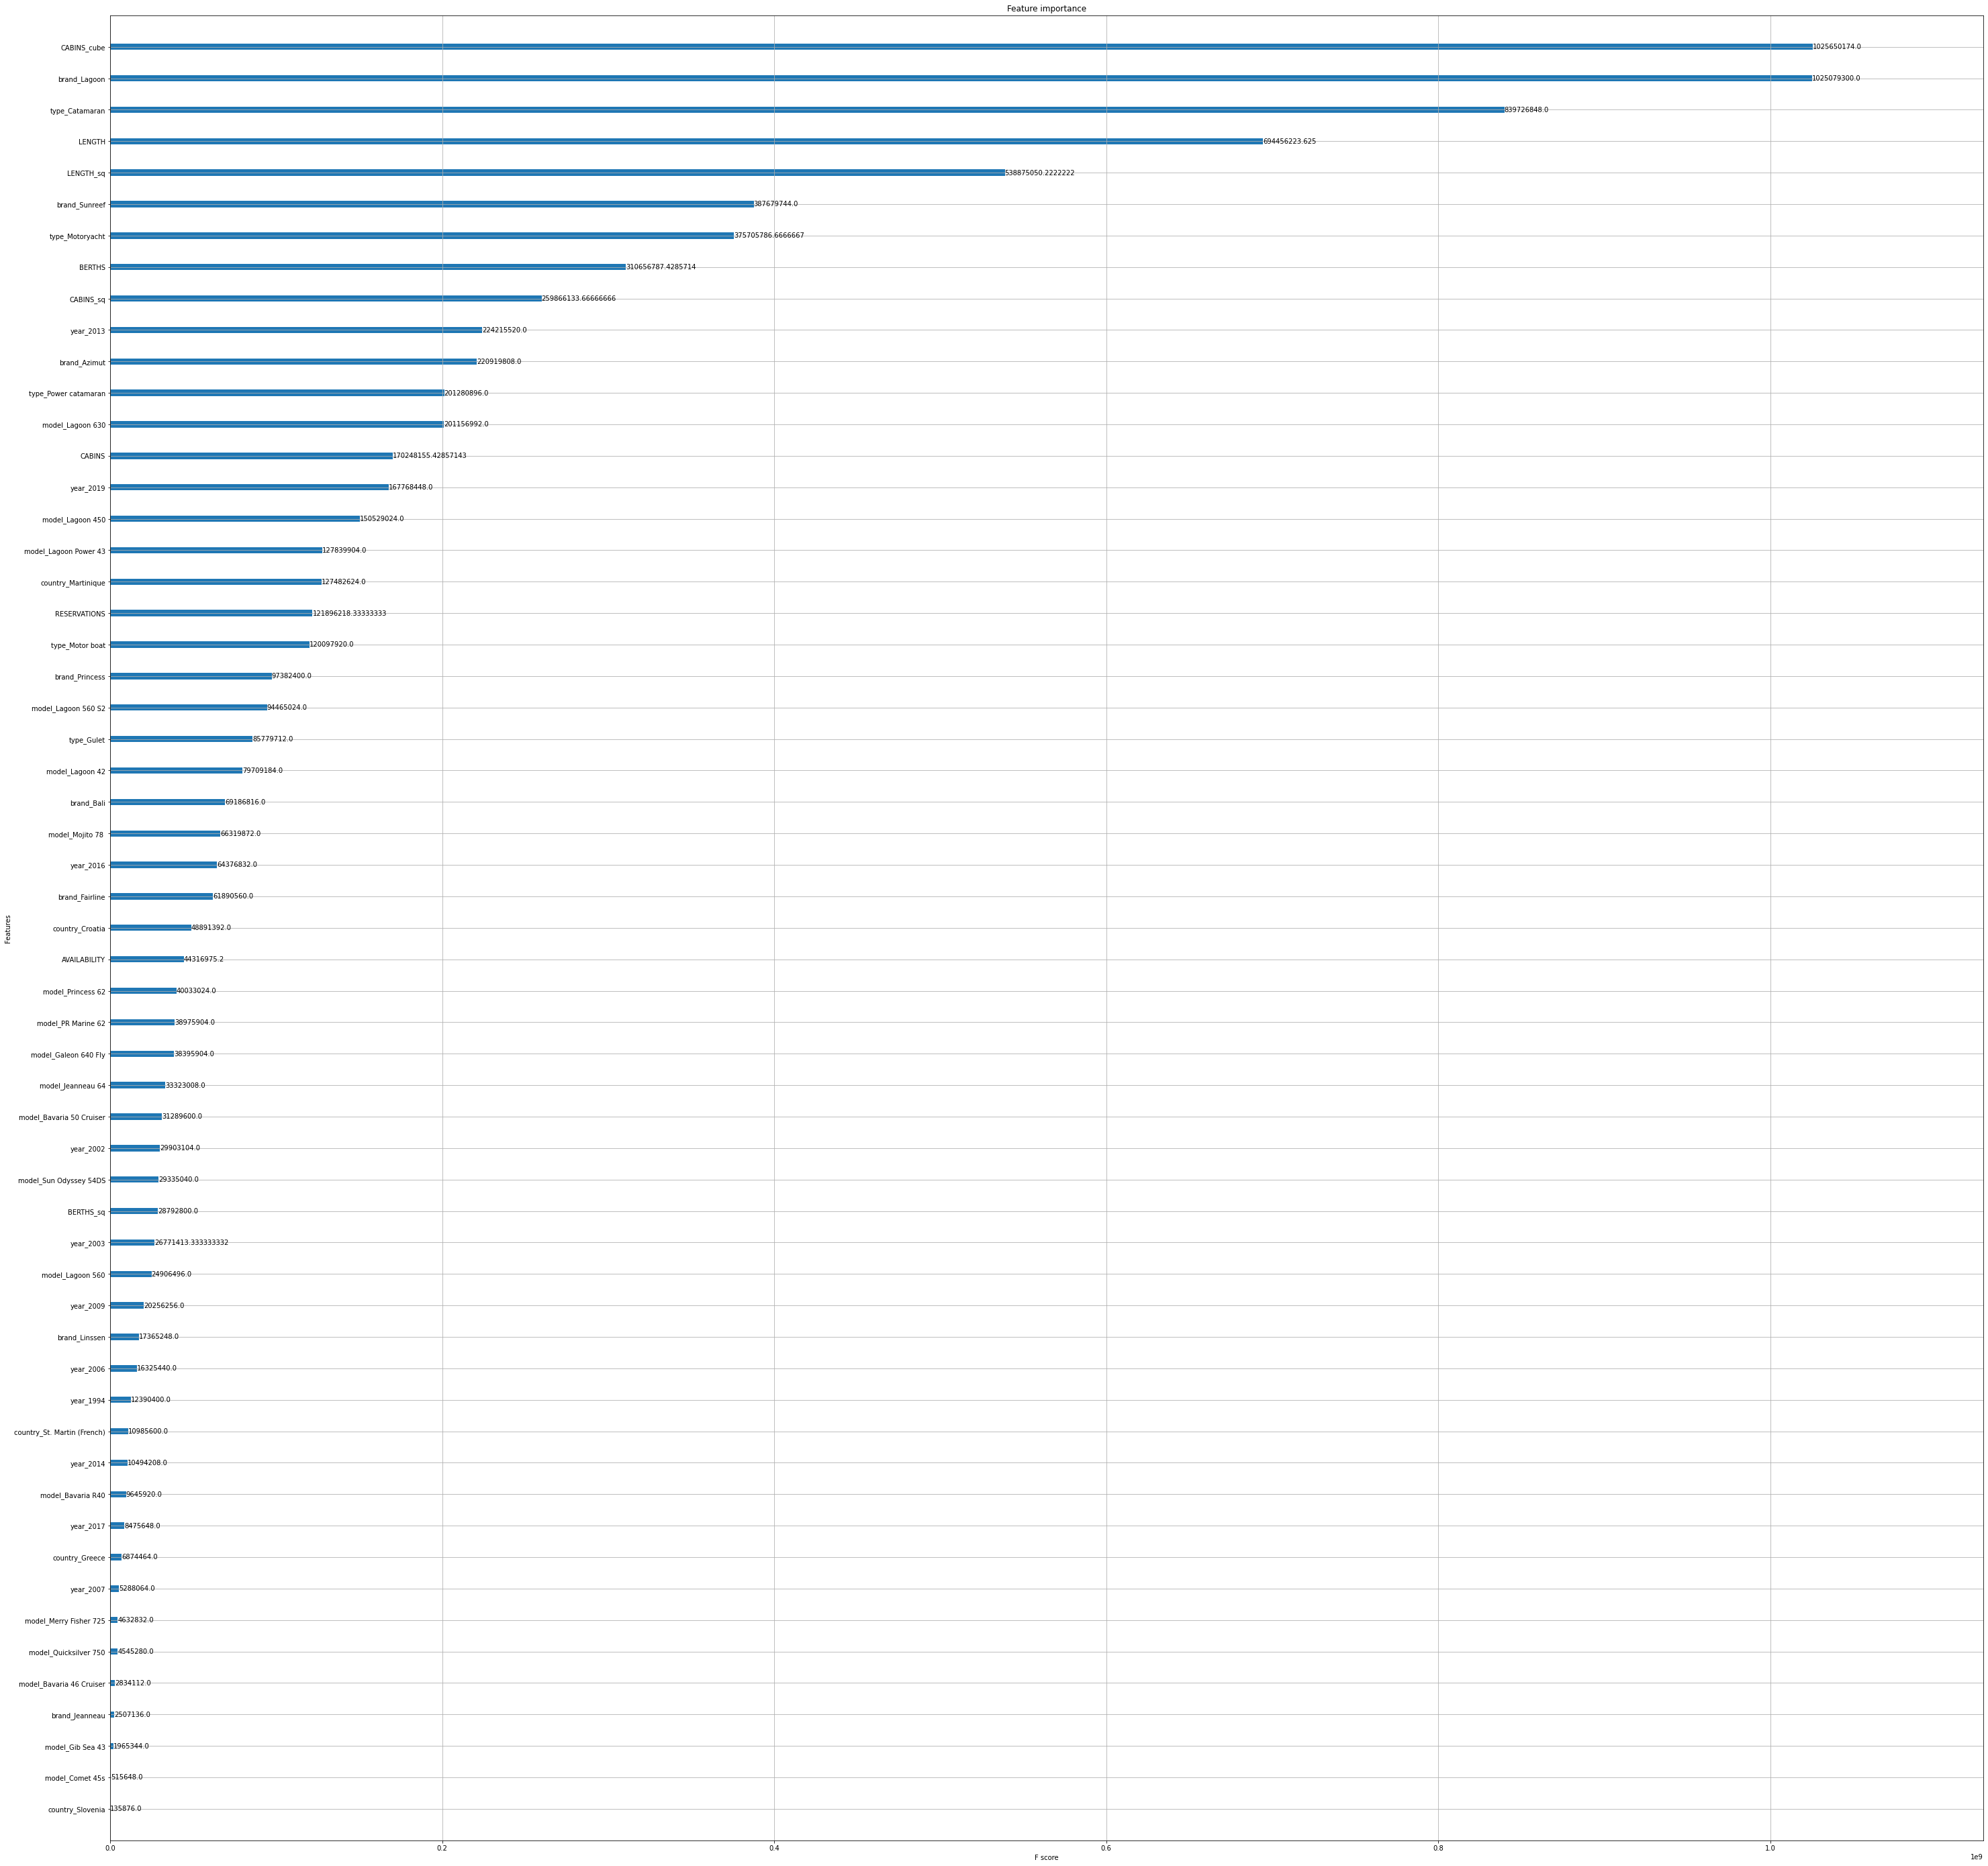

In [ ]:
# The average training loss reduction gained when using a feature for splitting.
xgb.plot_importance(xg_reg, importance_type= 'gain')
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

In [ ]:
# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.0001, 0.001, 0.01, 0.1]
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [ ]:
# grid_search = GridSearchCV(xg_reg, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X_train, y_train)

In [ ]:
import xgboost as xgb

In [ ]:
regrxgb = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regrxgb.fit(X_train,y_train)

[04:38:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=7200, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1, seed=42,
             silent=1, subsample=0.2, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
# Run prediction on training set to get a rough idea of how well it does.
y_pred = regrxgb.predict(X_test)
y_pred_xgb = y_pred
print("XGBoost RMSE score on test set: ", rmse(y_test, y_pred))

XGBoost RMSE score on test set:  898.1003557614829


Last score for rmse of XGBoost : 

In [ ]:
# Run prediction on the Kaggle test set.
#y_pred_xgb = regr.predict(test_df_munged)

################################################################################

from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(X_test)
#y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_lasso = regr.predict(X_test)

################################################################################

# Blend the results of the two regressors and save the prediction to a CSV file.

y_pred = (y_pred_xgb + y_pred_lasso) / 2
print("averaged score on training set: ", rmse(y_test, y_pred))

Lasso score on training set:  1246.4663524088596
averaged score on training set:  871.972980687535


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 289280448.2061432, tolerance: 1569184.3285784577



In [ ]:
rmse(y_test, y_pred)/np.median(y_test)

0.2416106901323178

In [ ]:
LassoCV(alphas=None, copy_X=True, cv=2, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

LassoCV(cv=2)

In [ ]:
regr.coef_

array([    0.        ,   558.58190589, -1478.42766084, ...,
        -258.36782099,     0.        ,     0.        ])

In [ ]:
result3Coef = pd.DataFrame(regr.coef_)
result3Coef.index = X2.columns
result3Coef[result3Coef != 0].head(10)

0
const                 NaN
AVAILABILITY   558.581906
LENGTH       -1478.427661
CABINS        -872.542287
BERTHS        -880.983603
RESERVATIONS     3.962358
LENGTH_sq       78.883107
BERTHS_sq      140.297441
CABINS_sq      398.647492
LENGTH_cube     -0.725328

# Neural Networks 

In [ ]:
XNN_train, XNN_test, yNN_train, yNN_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(XNN_train)
XNN_train = scaler.transform(XNN_train)
XNN_test = scaler.transform(XNN_test)

use MLP (-- not good since Classifier) 

In [ ]:
from sklearn.neural_network import MLPClassifier
# from numpy import ravel

In [ ]:
# mlp = MLPClassifier(max_iter=5000)

In [ ]:
# yNN_train = ravel(yNN_train)

In [ ]:
# modelNN = mlp.fit(XNN_train,yNN_train)

In [ ]:
# print(modelNN)

In [ ]:
# predictionsNN = mlp.predict(XNN_test)

In [ ]:
# mlp.score(XNN_train,yNN_train)

In [ ]:
# mlp.score(XNN_test,yNN_test)

In [ ]:
# from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# print(confusion_matrix(yNN_test,predictionsNN))
# conf = confusion_matrix(yNN_test,predictionsNN)

In [ ]:
# print(classification_report(yNN_test,predictionsNN))

In [ ]:
# labels = X2.columns
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(conf)
# plt.title('Confusion matrix of the classifier')
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# KERAS PACKAGE

## Without Hidden Layers

In [ ]:
from keras import Sequential
from keras.layers import Dense, Activation


model = Sequential()
# Input Layer
model.add(Dense(50, activation= 'relu', input_dim=XNN_train.shape[1])) 
# Hidden Layer - worse results --> because linear model? 
# Output Layer 
model.add(Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam', metrics= ['mse'])

In [ ]:
model.fit(XNN_train, yNN_train, epochs = 100, verbose = 1, validation_split = 0.2, validation_data = (XNN_test, yNN_test))

Epoch 1/100
38/38 [==============================] - 0s 5ms/step - loss: 30423950.0000 - mse: 30423950.0000 - val_loss: 29041092.0000 - val_mse: 29041092.0000
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 30388568.0000 - mse: 30388568.0000 - val_loss: 29006592.0000 - val_mse: 29006592.0000
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 30340018.0000 - mse: 30340018.0000 - val_loss: 28952712.0000 - val_mse: 28952712.0000
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 30271142.0000 - mse: 30271142.0000 - val_loss: 28878494.0000 - val_mse: 28878494.0000
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 30179400.0000 - mse: 30179400.0000 - val_loss: 28779612.0000 - val_mse: 28779612.0000
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 30062856.0000 - mse: 30062856.0000 - val_loss: 28656214.0000 - val_mse: 28656214.0000
Epoch 7/100
38/38 [===========================

In [ ]:
scoreNN1 = model.evaluate(XNN_test, yNN_test)
print((model.metrics_names, scoreNN1))

12/12 [==============================] - 0s 725us/step - loss: 2447039.2500 - mse: 2447039.2500
(['loss', 'mse'], [2447039.25, 2447039.25])


In [ ]:
rmseNN1 = np.sqrt(scoreNN1)
print(rmseNN1)

[1564.30152145 1564.30152145]


In [ ]:
predictionsNN1 = model.predict(XNN_test)

In [ ]:
rmseNN1 = np.sqrt(mean_squared_error(yNN_test, predictionsNN1))
rmse_normNN1 = rmseNN1 / np.median(yNN_test)

In [ ]:
print(rmse_normNN1)

0.4334445911110544


In [ ]:
print(rmseNN1)

1564.3015293197952


## With hidden layers

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.regularizers import l1,l2,l1_l2

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(3, kernel_initializer='normal',input_dim = XNN_train.shape[1], activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))

# The Hidden Layers :
NN_model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
NN_model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
NN_model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
NN_model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
NN_model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
NN_model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 3693      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
NN_model.fit(XNN_train, yNN_train, epochs = 100, validation_split = 0.2)

Epoch 1/100
38/38 [==============================] - 0s 7ms/step - loss: 30438514.0000 - mse: 30438456.0000 - val_loss: 29068914.0000 - val_mse: 29068884.0000
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 30437680.0000 - mse: 30437662.0000 - val_loss: 29067634.0000 - val_mse: 29067628.0000
Epoch 3/100
38/38 [==============================] - 0s 1ms/step - loss: 30435278.0000 - mse: 30435262.0000 - val_loss: 29062784.0000 - val_mse: 29062766.0000
Epoch 4/100
38/38 [==============================] - 0s 1ms/step - loss: 30420904.0000 - mse: 30420884.0000 - val_loss: 29023422.0000 - val_mse: 29023368.0000
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 30235896.0000 - mse: 30235804.0000 - val_loss: 28495298.0000 - val_mse: 28495176.0000
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 28207434.0000 - mse: 28207258.0000 - val_loss: 23426028.0000 - val_mse: 23425796.0000
Epoch 7/100
38/38 [===========================

In [ ]:
scoreNN2 = NN_model.evaluate(XNN_test, yNN_test)
print((NN_model.metrics_names, scoreNN2))

12/12 [==============================] - 0s 804us/step - loss: 1783221.7500 - mse: 1783032.1250
(['loss', 'mse'], [1783221.75, 1783032.125])


In [ ]:
rmseNN2 = np.sqrt(scoreNN2)
print(rmseNN2)

[1335.37326243 1335.30225979]


In [ ]:
predictionsNN2 = NN_model.predict(XNN_test)

In [ ]:
rmsepredNN2 = np.sqrt(mean_squared_error(yNN_test, predictionsNN2))
rmsepred_normNN2 = rmsepredNN2 / np.median(yNN_test)

In [ ]:
print(rmsepred_normNN2)

0.36999232778738755


In [ ]:
print(rmsepredNN2)

1335.3023109846818


## KFold to tune the parameters

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
XKF = X2.values
yKF = y2.values

In [ ]:
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=30, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(XKF, yKF):
    model = Sequential()
    
    model.add(Dense(3, kernel_initializer='normal',input_dim = XKF[train].shape[1], activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_regularizer = l1_l2(l1=0.5, l2=1)))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
    model.fit(XKF[train], yKF[train], epochs = 100, verbose = 0, validation_split=0.2)
    scores = model.evaluate(XKF[test], yKF[test], verbose = 0)
    print(model.metrics_names[1], scores[1])
    cvscores.append(scores[1])
print((np.mean(np.sqrt(cvscores))))

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=30.



mse 7026739.5
mse 2325206.5
mse 3271614.75
mse 3564465.25
mse 12389324.0
mse 5251133.5
mse 3221583.75
mse 3376135.75
mse 4235354.5
mse 4070107.0
mse 1713217.0
mse 3095002.5
mse 3385856.5
